# Capstone Project: NYC Crime Time Series Forecasting

## 1. Abstract / Introduction

US has been grappling with crimes for decades now and had made significant improvement. However, crime remains to be one of the core societal problems in the US and in New York City (NYC) specifically. To build a safer society, we can analyze crime patterns and forecast future occurrences of crime. In addition, there have been multiple research studies examining the relationship between socioeconomic status and crime statistics which can help to improve relations with the local communities.

In this project, we will explore the patterns of crimes in each NYC borough (the Bronx, Brooklyn, Manhattan, Queens, and Staten Island) and observe how socioeconomic factors (incomes, unemployment rate, and educational attainment) impacts the number of crimes. This can help criminal justice professionals and government officials understand whether their initiatives are successful. It also allows for a dialogue between law enforcement and the public they serve.

Specifically, in this project, we will forecast number of crimes in each borough in NYC using
- ARIMA: Past time points of time series data can impact current and future time points. ARIMA models take this concept into account when forecasting current and future values. ARIMA uses a number of lagged observations of time series to forecast observations. A weight is applied to each of the past term and the weights can vary based on how recent they are.

- Facebook Prophet: Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

- Holt-Winters Exponential Smoothing: Exponential smoothing assigns exponentially decreasing weights and values against historical data to decrease the value of the weight for the older data. It is used for forecasting time series data that exhibits both a trend and a seasonal variation.

In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("paper", font_scale = 1.4)
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pmdarima.arima import auto_arima
import math
import warnings
warnings.simplefilter("ignore")
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from fbprophet import Prophet
from matplotlib.pylab import rcParams
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.holtwinters import ExponentialSmoothing

## 2. Data Cleaning & Exploring

In [2]:
# load data
crimes = pd.read_csv('NYPD_Arrests_Data.csv')
education = pd.read_csv('Educational_Attainment.csv')
income = pd.read_csv('Median_Incomes.csv')
unemployment = pd.read_csv('Unemployment_Rate.csv')

### 2.1 - NYPD Arrests

In [3]:
# shape of crimes dataset
print(crimes.shape)

(5012956, 19)


In [4]:
# head of crimes dataset
crimes.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,10837169,04/02/2006,NaN,NaN,NaN,NaN,NaN,NaN,Q,101,0.0,NaN,M,BLACK,1051775.0,159727.0,40.604841,-73.756823,POINT (-73.75682250899997 40.604840985000074)
1,189797412,11/09/2018,475.0,NaN,NaN,NaN,PL 1651601,M,M,28,1.0,25-44,F,WHITE HISPANIC,997374.0,234664.0,40.810773,-73.952592,POINT (-73.95259158999993 40.81077276700007)
2,189992103,11/14/2018,475.0,NaN,NaN,NaN,PL 1651601,M,K,75,1.0,18-24,M,BLACK,1021568.0,185710.0,40.676337,-73.865464,POINT (-73.86546353999995 40.676337363000066)
3,189714430,11/07/2018,117.0,RECKLESS ENDANGERMENT 1,126.0,MISCELLANEOUS PENAL LAW,PL 1202500,F,M,26,0.0,45-64,M,WHITE,993685.0,233346.0,40.807160,-73.965920,POINT (-73.96591978699998 40.80715993100006)
4,190067816,11/15/2018,586.0,NaN,NaN,NaN,PL 230341A,F,M,5,0.0,18-24,M,BLACK,984946.0,200203.0,40.716196,-73.997491,POINT (-73.99749074599998 40.716195914000025)


In [5]:
# tail of crimes dataset
crimes.tail()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
5012951,206858026,12/27/2019,478.0,"THEFT OF SERVICES, UNCLASSIFIE",343.0,OTHER OFFENSES RELATED TO THEF,PL 1651503,M,K,73,0.0,25-44,M,BLACK,1008992.0,186404.0,40.678286,-73.910800,POINT (-73.91079962899994 40.67828631700008)
5012952,205304150,11/18/2019,922.0,"TRAFFIC,UNCLASSIFIED MISDEMEAN",348.0,VEHICLE AND TRAFFIC LAWS,VTL05110A4,M,Q,114,4.0,25-44,M,BLACK,1006898.0,220358.0,40.771487,-73.918235,POINT (-73.91823481899996 40.771487379000064)
5012953,205307020,11/18/2019,922.0,"TRAFFIC,UNCLASSIFIED MISDEMEAN",348.0,VEHICLE AND TRAFFIC LAWS,VTL05110EA,F,S,123,0.0,25-44,M,BLACK HISPANIC,923891.0,141449.0,40.554723,-74.217210,POINT (-74.21721022099996 40.55472331800007)
5012954,206301725,12/10/2019,779.0,"PUBLIC ADMINISTRATION,UNCLASSI",126.0,MISCELLANEOUS PENAL LAW,PL 215510B,F,Q,110,0.0,25-44,M,WHITE HISPANIC,1020237.0,210724.0,40.745000,-73.870128,POINT (-73.87012832399995 40.74500029700005)
5012955,206235317,12/09/2019,109.0,"ASSAULT 2,1,UNCLASSIFIED",106.0,FELONY ASSAULT,PL 1200502,F,M,33,0.0,45-64,M,BLACK,1001174.0,244309.0,40.837239,-73.938840,POINT (-73.93883993799994 40.83723909200006)


In [6]:
# dropping unnecessary columns
crimes = crimes.drop(['ARREST_KEY', 'PD_CD', 'PD_DESC', 'KY_CD', 'LAW_CODE', 'LAW_CAT_CD', 'ARREST_PRECINCT', 'AGE_GROUP',
                      'JURISDICTION_CODE', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude', 'Lon_Lat'], axis = 1)

In [7]:
# check null values
crimes.isna().sum()

ARREST_DATE       0
OFNS_DESC      9029
ARREST_BORO       8
PERP_SEX          0
PERP_RACE         0
dtype: int64

In [8]:
# drop null values
crimes = crimes.dropna(how='any',axis=0) 

In [9]:
# check null values again (all null values should be gone)
crimes.isna().sum()

ARREST_DATE    0
OFNS_DESC      0
ARREST_BORO    0
PERP_SEX       0
PERP_RACE      0
dtype: int64

In [10]:
# rename columns
crimes.rename(columns = {'ARREST_DATE':'Arrest_Date', 'OFNS_DESC': 'Crime', 'ARREST_BORO': 'Borough',
                         'PERP_SEX':'Perp_Gender', 'PERP_RACE':'Perp_Race'}, inplace = True)

In [11]:
# check data types
crimes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5003919 entries, 3 to 5012955
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   Arrest_Date  object
 1   Crime        object
 2   Borough      object
 3   Perp_Gender  object
 4   Perp_Race    object
dtypes: object(5)
memory usage: 229.1+ MB


In [12]:
# change Arrest_Date to datetime datatypes
crimes['Arrest_Date'] = pd.to_datetime(crimes['Arrest_Date'], format='%m/%d/%Y')

In [13]:
# set Arrest_Date as index  
crimes = crimes.set_index('Arrest_Date')

In [14]:
# check values of Crime column
pd.set_option('display.max_rows', None)
crimes['Crime'].value_counts()

DANGEROUS DRUGS                                1077446
ASSAULT 3 & RELATED OFFENSES                    491876
OTHER OFFENSES RELATED TO THEFT                 304190
OTHER STATE LAWS                                241244
PETIT LARCENY                                   209987
VEHICLE AND TRAFFIC LAWS                        200292
CRIMINAL TRESPASS                               199431
FELONY ASSAULT                                  196758
DANGEROUS WEAPONS                               190847
MISCELLANEOUS PENAL LAW                         176794
OTHER TRAFFIC INFRACTION                        174428
OFFENSES AGAINST PUBLIC ADMINISTRATION          156544
ROBBERY                                         153339
POSSESSION OF STOLEN PROPERTY 5                 149876
CRIMINAL MISCHIEF & RELATED OFFENSES            146039
GRAND LARCENY                                   119445
INTOXICATED & IMPAIRED DRIVING                   99338
FORGERY                                          82649
OTHER STAT

In [15]:
# cleaning up crime descriptions
crimes['Crime'].replace('ADMINISTRATIVE CODE', 'ADMINISTRATIVE CODES', inplace=True)
crimes['Crime'].replace('FORCIBLE TOUCHING', 'ASSAULT/HARASSMENT & RELATED OFFENSES', inplace=True)
crimes['Crime'].replace('ASSAULT 3 & RELATED OFFENSES', 'ASSAULT/HARASSMENT & RELATED OFFENSES', inplace=True)
crimes['Crime'].replace('FELONY ASSAULT', 'ASSAULT/HARASSMENT & RELATED OFFENSES', inplace=True)
crimes['Crime'].replace('HARASSMENT', 'ASSAULT/HARASSMENT & RELATED OFFENSES', inplace=True)
crimes['Crime'].replace('HARRASSMENT 2', 'ASSAULT/HARASSMENT & RELATED OFFENSES', inplace=True)
crimes['Crime'].replace("BURGLAR'S TOOLS", 'BURGLARY', inplace=True)
crimes['Crime'].replace('CRIMINAL MISCHIEF & RELATED OF', 'CRIMINAL MISCHIEF & RELATED OFFENSES', inplace=True)
crimes['Crime'].replace('UNDER THE INFLUENCE, DRUGS', 'DANGEROUS DRUGS', inplace=True)
crimes['Crime'].replace('UNLAWFUL POSS. WEAP. ON SCHOOL', 'DANGEROUS WEAPONS', inplace=True)
crimes['Crime'].replace('UNLAWFUL POSS. WEAP. ON SCHOOL GROUNDS', 'DANGEROUS WEAPONS', inplace=True)
crimes['Crime'].replace('FORGERY', 'FRAUDS', inplace=True)
crimes['Crime'].replace('FRAUDULENT ACCOSTING', 'FRAUDS', inplace=True)
crimes['Crime'].replace('OFFENSES INVOLVING FRAUD', 'FRAUDS', inplace=True)
crimes['Crime'].replace('HOMICIDE-NEGLIGENT,UNCLASSIFIE', 'HOMICIDE-NEGLIGENT', inplace=True)
crimes['Crime'].replace('HOMICIDE-NEGLIGENT,UNCLASSIFIED', 'HOMICIDE-NEGLIGENT', inplace=True)
crimes['Crime'].replace('HOMICIDE-NEGLIGENT-VEHICLE', 'HOMICIDE-NEGLIGENT', inplace=True)
crimes['Crime'].replace('INTOXICATED/IMPAIRED DRIVING', 'INTOXICATED & IMPAIRED DRIVING', inplace=True)
crimes['Crime'].replace('KIDNAPPING', 'KIDNAPPING & RELATED OFFENSES', inplace=True)
crimes['Crime'].replace('PETIT LARCENY', 'LARCENY', inplace=True)
crimes['Crime'].replace('GRAND LARCENY', 'LARCENY', inplace=True)
crimes['Crime'].replace('GRAND LARCENY OF MOTOR VEHICLE', 'LARCENY', inplace=True)
crimes['Crime'].replace('GAMBLING', 'LOITERING/GAMBLING', inplace=True)
crimes['Crime'].replace('LOITERING', 'LOITERING/GAMBLING', inplace=True)
crimes['Crime'].replace('LOITERING FOR DRUG PURPOSES', 'LOITERING/GAMBLING', inplace=True)
crimes['Crime'].replace('LOITERING,BEGGING', 'LOITERING/GAMBLING', inplace=True)
crimes['Crime'].replace('LOITERING/GAMBLING (CARDS, DIC', 'LOITERING/GAMBLING', inplace=True)
crimes['Crime'].replace('LOITERING/GAMBLING (CARDS, DICE, ETC)', 'LOITERING/GAMBLING', inplace=True)
crimes['Crime'].replace('MURDER & NON-NEGL. MANSLAUGHTE', 'MURDER & NON-NEGL. MANSLAUGHTER', inplace=True)
crimes['Crime'].replace('DISORDERLY CONDUCT', 'OFFENSES AGAINST PUBLIC ORDER/SAFETY', inplace=True)
crimes['Crime'].replace('DISRUPTION OF A RELIGIOUS SERV', 'OFFENSES AGAINST PUBLIC ORDER/SAFETY', inplace=True)
crimes['Crime'].replace('DISRUPTION OF A RELIGIOUS SERVICE', 'OFFENSES AGAINST PUBLIC ORDER/SAFETY', inplace=True)
crimes['Crime'].replace('ENDAN WELFARE INCOMP', 'OFFENSES AGAINST PUBLIC ORDER/SAFETY', inplace=True)
crimes['Crime'].replace('FOR OTHER AUTHORITIES', 'OFFENSES AGAINST PUBLIC ORDER/SAFETY', inplace=True)
crimes['Crime'].replace('OFF. AGNST PUB ORD SENSBLTY &', 'OFFENSES AGAINST PUBLIC ORDER/SAFETY', inplace=True)
crimes['Crime'].replace('OFF. AGNST PUB ORD SENSBLTY & RGHTS TO PRIV', 'OFFENSES AGAINST PUBLIC ORDER/SAFETY', inplace=True)
crimes['Crime'].replace('OFFENSES AGAINST PUBLIC ADMINI', 'OFFENSES AGAINST PUBLIC ORDER/SAFETY', inplace=True)
crimes['Crime'].replace('OFFENSES AGAINST PUBLIC ADMINISTRATION', 'OFFENSES AGAINST PUBLIC ORDER/SAFETY', inplace=True)
crimes['Crime'].replace('OFFENSES AGAINST PUBLIC SAFETY', 'OFFENSES AGAINST PUBLIC ORDER/SAFETY', inplace=True)
crimes['Crime'].replace('JOSTLING', 'OFFENSES AGAINST THE PERSON', inplace=True)
crimes['Crime'].replace('CHILD ABANDONMENT/NON SUPPORT', 'OFFENSES RELATED TO CHILDREN', inplace=True)
crimes['Crime'].replace('CHILD ABANDONMENT/NON SUPPORT 1', 'OFFENSES RELATED TO CHILDREN', inplace=True)
crimes['Crime'].replace('ABORTION', 'OTHER STATE LAWS', inplace=True)
crimes['Crime'].replace('AGRICULTURE & MRKTS LAW-UNCLASSIFIED', 'OTHER STATE LAWS', inplace=True)
crimes['Crime'].replace('ESCAPE 3', 'OTHER STATE LAWS', inplace=True)
crimes['Crime'].replace('F.C.A. P.I.N.O.S.', 'OTHER STATE LAWS', inplace=True)
crimes['Crime'].replace('FORTUNE TELLING', 'OTHER STATE LAWS', inplace=True)
crimes['Crime'].replace('MISCELLANEOUS PENAL LAW', 'OTHER STATE LAWS', inplace=True)
crimes['Crime'].replace('NEW YORK CITY HEALTH CODE', 'OTHER STATE LAWS', inplace=True)
crimes['Crime'].replace('NYS LAWS-UNCLASSIFIED FELONY', 'OTHER STATE LAWS', inplace=True)
crimes['Crime'].replace('NYS LAWS-UNCLASSIFIED VIOLATION', 'OTHER STATE LAWS', inplace=True)
crimes['Crime'].replace('OFFENSES AGAINST MARRIAGE UNCLASSIFIED', 'OTHER STATE LAWS', inplace=True)
crimes['Crime'].replace('OTHER STATE LAWS (NON PENAL LA', 'OTHER STATE LAWS', inplace=True)
crimes['Crime'].replace('OTHER STATE LAWS (NON PENAL LAW)', 'OTHER STATE LAWS', inplace=True)
crimes['Crime'].replace('POSSESSION OF STOLEN PROPERTY 5', 'POSSESSION OF STOLEN PROPERTY', inplace=True)
crimes['Crime'].replace('RAPE', 'RAPE & SEX CRIMES', inplace=True)
crimes['Crime'].replace('SEX CRIMES', 'RAPE & SEX CRIMES', inplace=True)
crimes['Crime'].replace('OTHER OFFENSES RELATED TO THEF', 'THEFT', inplace=True)
crimes['Crime'].replace('OTHER OFFENSES RELATED TO THEFT', 'THEFT', inplace=True)
crimes['Crime'].replace('THEFT OF SERVICES', 'THEFT', inplace=True)
crimes['Crime'].replace('THEFT-FRAUD', 'THEFT', inplace=True)
crimes['Crime'].replace('MOVING INFRACTIONS', 'VEHICLE AND TRAFFIC LAWS', inplace=True)
crimes['Crime'].replace('OTHER TRAFFIC INFRACTION', 'VEHICLE AND TRAFFIC LAWS', inplace=True)
crimes['Crime'].replace('PARKING OFFENSES', 'VEHICLE AND TRAFFIC LAWS', inplace=True)
crimes['Crime'].replace('UNAUTHORIZED USE OF A VEHICLE', 'VEHICLE AND TRAFFIC LAWS', inplace=True)
crimes['Crime'].replace('UNAUTHORIZED USE OF A VEHICLE 3 (UUV)', 'VEHICLE AND TRAFFIC LAWS', inplace=True)

In [16]:
# check Crime values again
crimes['Crime'].value_counts()

DANGEROUS DRUGS                          1077457
ASSAULT/HARASSMENT & RELATED OFFENSES     711916
OTHER STATE LAWS                          522450
VEHICLE AND TRAFFIC LAWS                  395039
LARCENY                                   344739
THEFT                                     318058
OFFENSES AGAINST PUBLIC ORDER/SAFETY      275572
CRIMINAL TRESPASS                         199431
DANGEROUS WEAPONS                         190911
POSSESSION OF STOLEN PROPERTY             168678
CRIMINAL MISCHIEF & RELATED OFFENSES      157804
ROBBERY                                   153339
FRAUDS                                    130687
INTOXICATED & IMPAIRED DRIVING            110542
BURGLARY                                   73499
RAPE & SEX CRIMES                          47206
PROSTITUTION & RELATED OFFENSES            46634
OFFENSES AGAINST THE PERSON                23351
LOITERING/GAMBLING                         15291
ADMINISTRATIVE CODES                       14304
MURDER & NON-NEGL. M

In [17]:
# check borough values
crimes['Borough'].value_counts()

K    1392125
M    1353704
B    1143439
Q     939334
S     175317
Name: Borough, dtype: int64

In [18]:
# replace letter boroughs with their names
crimes['Borough'].replace('K', 'Brooklyn', inplace=True)
crimes['Borough'].replace('M', 'Manhattan', inplace=True)
crimes['Borough'].replace('B', 'Bronx', inplace=True)
crimes['Borough'].replace('Q', 'Queens', inplace=True)
crimes['Borough'].replace('S', 'Staten Island', inplace=True)

In [19]:
# checking 
crimes['Borough'].value_counts()

Brooklyn         1392125
Manhattan        1353704
Bronx            1143439
Queens            939334
Staten Island     175317
Name: Borough, dtype: int64

In [20]:
# check gender
crimes['Perp_Gender'].value_counts()

M    4163184
F     840735
Name: Perp_Gender, dtype: int64

In [21]:
# check race
crimes['Perp_Race'].value_counts()

BLACK                             2428046
WHITE HISPANIC                    1301556
WHITE                              604317
BLACK HISPANIC                     402337
ASIAN / PACIFIC ISLANDER           204970
UNKNOWN                             50285
AMERICAN INDIAN/ALASKAN NATIVE      11045
OTHER                                1363
Name: Perp_Race, dtype: int64

In [22]:
# check datatypes for cleaned crimes dataset
crimes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5003919 entries, 2018-11-07 to 2019-12-09
Data columns (total 4 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   Crime        object
 1   Borough      object
 2   Perp_Gender  object
 3   Perp_Race    object
dtypes: object(4)
memory usage: 190.9+ MB


In [23]:
# view head of our cleaned crimes dataset
crimes.head()

,Crime,Borough,Perp_Gender,Perp_Race
Arrest_Date,,,,
2018-11-07,OTHER STATE LAWS,Manhattan,M,WHITE
2018-11-15,ASSAULT/HARASSMENT & RELATED OFFENSES,Bronx,M,BLACK
2018-11-07,RAPE & SEX CRIMES,Bronx,M,BLACK
2018-10-22,ASSAULT/HARASSMENT & RELATED OFFENSES,Brooklyn,M,BLACK
2009-09-17,RAPE & SEX CRIMES,Staten Island,M,BLACK HISPANIC


### 2.2 - Educational Attainment

In [24]:
# shape of education dataframe
print(education.shape)

(9099, 6)


In [25]:
# head of education dataframe
education.head()

,Location,Education Level,TimeFrame,DataFormat,Data,Fips
0,Riverdale,Less than High School Degree,2017,Number,13845.00000,208
1,Williamsbridge,Less than High School Degree,2017,Number,20069.00000,212
2,Throgs Neck,Less than High School Degree,2017,Number,12268.00000,210
3,Pelham Parkway,Less than High School Degree,2017,Number,17150.00000,211
4,Morrisania,Less than High School Degree,2017,Number,20471.57803,203


In [26]:
# tail of education dataframe
education.tail()

,Location,Education Level,TimeFrame,DataFormat,Data,Fips
9094,Brooklyn,Some College,2019,Percent,0.12175,36047
9095,Manhattan,Some College,2019,Percent,0.09641,36061
9096,Queens,Some College,2019,Percent,0.14482,36081
9097,Staten Island,Some College,2019,Percent,0.16326,36085
9098,New York City,Some College,2019,Percent,0.13287,3651000


In [27]:
# check null values
education.isna().sum()

Location           0
Education Level    0
TimeFrame          0
DataFormat         0
Data               0
Fips               0
dtype: int64

In [28]:
# check data types
education.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9099 entries, 0 to 9098
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Location         9099 non-null   object 
 1   Education Level  9099 non-null   object 
 2   TimeFrame        9099 non-null   int64  
 3   DataFormat       9099 non-null   object 
 4   Data             9099 non-null   float64
 5   Fips             9099 non-null   int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 426.6+ KB


In [29]:
# check location values
education['Location'].value_counts()

Upper East Side              140
Flatbush/Midwood             140
Queens Village               140
Brownsville                  140
Flushing                     140
Fresh Meadows/Briarwood      140
Borough Park                 140
Jackson Heights              140
Bedford Stuyvesant           140
East Flatbush                140
Astoria                      140
Battery Park/Tribeca         140
East Tremont                 140
Tottenville                  140
Throgs Neck                  140
Lower East Side              140
Bedford Park                 140
Jamaica/St. Albans           140
Greenwich Village            140
Williamsbridge               140
Bayside                      140
South Beach                  140
New York City                140
Fort Greene/Brooklyn Hts     140
The Rockaways                140
Sunset Park                  140
Bronx                        140
Brooklyn                     140
Williamsburg/Greenpoint      140
Washington Heights           140
Pelham Par

In [30]:
# only keep 5 boroughs
education = education[education["Location"].str.contains("Brooklyn|Manhattan|Bronx|Queens|Staten Island")]

In [31]:
# check location values again
education['Location'].value_counts()

Queens                      140
Fort Greene/Brooklyn Hts    140
Manhattanville              140
Staten Island               140
Manhattan                   140
Bronx                       140
Brooklyn                    140
Queens Village              140
Name: Location, dtype: int64

In [32]:
# removing unintended values
education = education[education.Location != 'Manhattanville']
education = education[education.Location != 'Fort Greene/Brooklyn Hts']
education = education[education.Location != 'Queens Village']

In [33]:
# checking location values again
education['Location'].value_counts()

Queens           140
Staten Island    140
Manhattan        140
Bronx            140
Brooklyn         140
Name: Location, dtype: int64

In [34]:
# check education level
education['Education Level'].value_counts()

Bachelor's Degree or Higher     140
Associate's Degree              140
Less than High School Degree    140
High School Degree              140
Some College                    140
Name: Education Level, dtype: int64

In [35]:
# check time periods
education['TimeFrame'].value_counts()

2019    50
2018    50
2017    50
2016    50
2015    50
2014    50
2013    50
2012    50
2011    50
2010    50
2009    50
2008    50
2007    50
2006    50
Name: TimeFrame, dtype: int64

In [36]:
# check dataformat
education['DataFormat'].value_counts()

Percent    350
Number     350
Name: DataFormat, dtype: int64

In [37]:
# rename columns
education.rename(columns = {'Location':'Borough', 'Education Level': 'Education_Level',
                            'DataFormat':'Data_Format', 'TimeFrame':'Year', 'Data':'Attainment_Rate'}, inplace = True)

In [38]:
education = education[education.Data_Format != 'Number']

In [39]:
education['Data_Format'].value_counts()

Percent    350
Name: Data_Format, dtype: int64

In [40]:
# dropping unnecessary columns
education = education.drop(['Data_Format'], axis = 1)
education = education.drop(['Fips'], axis = 1)

In [41]:
# change datatype
education['Year'] = pd.to_datetime(education['Year'], format='%Y')
# set index with time
education = education.set_index('Year')

In [42]:
# view cleaned datatypes
education.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 350 entries, 2017-01-01 to 2019-01-01
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Borough          350 non-null    object 
 1   Education_Level  350 non-null    object 
 2   Attainment_Rate  350 non-null    float64
dtypes: float64(1), object(2)
memory usage: 10.9+ KB


In [43]:
# view cleaned dataframe
education.head()

,Borough,Education_Level,Attainment_Rate
Year,,,
2017-01-01,Bronx,Less than High School Degree,0.28078
2017-01-01,Brooklyn,Less than High School Degree,0.17102
2017-01-01,Manhattan,Less than High School Degree,0.13957
2017-01-01,Queens,Less than High School Degree,0.17990
2017-01-01,Staten Island,Less than High School Degree,0.11683


### 2.3 - Median Incomes

In [44]:
# shape of income dataframe
print(income.shape)

(6068, 6)


In [45]:
# head of income dataframe
income.head()

,Location,Household Type,TimeFrame,DataFormat,Data,Fips
0,New York City,All Households,2005,Dollars,56998.60927,3651000
1,New York City,Families,2005,Dollars,64793.69467,3651000
2,New York City,Families with Children,2005,Dollars,55448.77832,3651000
3,New York City,Families without Children,2005,Dollars,72309.25932,3651000
4,New York City,All Households,2006,Dollars,59080.75625,3651000


In [46]:
# tail of income dataframe
income.tail()

,Location,Household Type,TimeFrame,DataFormat,Data,Fips
6063,Zip Code 11697,Families without Children,2018,Dollars,107920.4976,11697
6064,Zip Code 11697,All Households,2019,Dollars,105750,11697
6065,Zip Code 11697,All Households,2018,Dollars,105456.6522,11697
6066,Zip Code 11697,All Households,2017,Dollars,104076.6981,11697
6067,Zip Code 11697,Families without Children,2017,Dollars,98210.18144,11697


In [47]:
# check null values
income.isna().sum()

Location          0
Household Type    0
TimeFrame         0
DataFormat        0
Data              0
Fips              0
dtype: int64

In [48]:
# check location values
income['Location'].value_counts()

East Flatbush                60
Williamsbridge               60
Queens                       60
Chelsea/Clinton              60
Coney Island                 60
Midtown Business District    60
Sheepshead Bay               60
Unionport/Soundview          60
Bayside                      60
Canarsie                     60
South Beach                  60
East New York                60
Queens Village               60
Tottenville                  60
Bedford Park                 60
Crown Heights North          60
Brownsville                  60
Bensonhurst                  60
Manhattanville               60
Morrisania                   60
East Harlem                  60
Jamaica/St. Albans           60
University Heights           60
Woodhaven                    60
Sunnyside/Woodside           60
Crown Heights South          60
Greenwich Village            60
Staten Island                60
Lower East Side              60
Throgs Neck                  60
Hunts Point                  60
St. Geor

In [49]:
# only keep 5 boroughs
income = income[income["Location"].str.contains("Brooklyn|Manhattan|Bronx|Queens|Staten Island")]
income = income[income.Location != 'Manhattanville']
income = income[income.Location != 'Fort Greene/Brooklyn Hts']
income = income[income.Location != 'Queens Village']

In [50]:
# checking location values again
income['Location'].value_counts()

Queens           60
Staten Island    60
Manhattan        60
Bronx            60
Brooklyn         60
Name: Location, dtype: int64

In [51]:
# check education level
income['Household Type'].value_counts()

Families with Children       75
All Households               75
Families without Children    75
Families                     75
Name: Household Type, dtype: int64

In [52]:
# check dataformat
income['DataFormat'].value_counts()

Dollars    300
Name: DataFormat, dtype: int64

In [53]:
# check time periods
income['TimeFrame'].value_counts()

2019    20
2018    20
2017    20
2016    20
2015    20
2014    20
2013    20
2012    20
2011    20
2010    20
2009    20
2008    20
2007    20
2006    20
2005    20
Name: TimeFrame, dtype: int64

In [54]:
# dropping unnecessary columns
income = income.drop(['DataFormat'], axis = 1)
income = income.drop(['Fips'], axis = 1)

In [55]:
# rename columns
income.rename(columns = {'Location':'Borough', 'Household Type': 'Household_Type', 
                         'Data': 'Income', 'TimeFrame':'Year'}, inplace = True)

In [56]:
# check data types
income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 60 to 3719
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Borough         300 non-null    object
 1   Household_Type  300 non-null    object
 2   Year            300 non-null    int64 
 3   Income          300 non-null    object
dtypes: int64(1), object(3)
memory usage: 11.7+ KB


In [57]:
# change data types
income['Year'] = pd.to_datetime(income['Year'], format='%Y')
income['Income'] = income['Income'].astype(float)
# set index with time
income = income.set_index('Year')

In [58]:
# filter household types
income = income[income.Household_Type != 'Families without Children']
income = income[income.Household_Type != 'Families']
income = income[income.Household_Type != 'Families with Children']

income = income.drop(['Household_Type'], axis = 1)

In [59]:
income.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 75 entries, 2018-01-01 to 2005-01-01
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Borough  75 non-null     object 
 1   Income   75 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.8+ KB


In [60]:
# view head of cleaned income dataframe
income.head()

,Borough,Income
Year,,
2018-01-01,Manhattan,86607.21741
2019-01-01,Manhattan,93651.00000
2017-01-01,Manhattan,88723.63296
2016-01-01,Manhattan,82628.64601
2015-01-01,Manhattan,81553.41788


### 2.4 - Unemployment Rate

In [61]:
# shape of unemployment dataframe
print(unemployment.shape)

(972, 5)


In [62]:
# head of unemployment dataframe
unemployment.head()

,Location,TimeFrame,DataFormat,Data,Fips
0,New York City,2005,Percent,0.08400,3651000
1,New York City,2006,Percent,0.07798,3651000
2,New York City,2007,Percent,0.07072,3651000
3,New York City,2008,Percent,0.07220,3651000
4,New York City,2009,Percent,0.10211,3651000


In [63]:
# tail of unemployment dataframe
unemployment.tail()

,Location,TimeFrame,DataFormat,Data,Fips
967,Tottenville,2015,Percent,0.056,503
968,Tottenville,2016,Percent,0.052,503
969,Tottenville,2017,Percent,0.044,503
970,Tottenville,2019,Percent,0.031,503
971,Tottenville,2018,Percent,0.028,503


In [64]:
# check null values
unemployment.isna().sum()

Location      0
TimeFrame     0
DataFormat    0
Data          0
Fips          0
dtype: int64

In [65]:
# check data types
unemployment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 972 entries, 0 to 971
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Location    972 non-null    object 
 1   TimeFrame   972 non-null    int64  
 2   DataFormat  972 non-null    object 
 3   Data        972 non-null    float64
 4   Fips        972 non-null    int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 38.1+ KB


In [66]:
# check location values
unemployment['Location'].value_counts()

Chelsea/Clinton              15
Queens                       15
Bayside                      15
Bedford Stuyvesant           15
Bronx                        15
Lower East Side              15
Canarsie                     15
Brooklyn                     15
Howard Beach                 15
East Harlem                  15
Coney Island                 15
Tottenville                  15
The Rockaways                15
Sheepshead Bay               15
East Flatbush                15
Astoria                      15
Williamsburg/Greenpoint      15
Washington Heights           15
Unionport/Soundview          15
Bedford Park                 15
Battery Park/Tribeca         15
University Heights           15
Pelham Parkway               15
Brownsville                  15
Midtown Business District    15
East New York                15
Woodhaven                    15
Queens Village               15
Bay Ridge                    15
Concourse/Highbridge         15
New York City                15
Williams

In [67]:
# only keep 5 boroughs
unemployment = unemployment[unemployment["Location"].str.contains("Brooklyn|Manhattan|Bronx|Queens|Staten Island")]
unemployment = unemployment[unemployment.Location != 'Manhattanville']
unemployment = unemployment[unemployment.Location != 'Fort Greene/Brooklyn Hts']
unemployment = unemployment[unemployment.Location != 'Queens Village']

In [68]:
# checking location values again
unemployment['Location'].value_counts()

Brooklyn         15
Queens           15
Staten Island    15
Manhattan        15
Bronx            15
Name: Location, dtype: int64

In [69]:
# check time periods
unemployment['TimeFrame'].value_counts()

2019    5
2018    5
2017    5
2016    5
2015    5
2014    5
2013    5
2012    5
2011    5
2010    5
2009    5
2008    5
2007    5
2006    5
2005    5
Name: TimeFrame, dtype: int64

In [70]:
# check dataformat
unemployment['DataFormat'].value_counts()

Percent    75
Name: DataFormat, dtype: int64

In [71]:
# dropping unnecessary columns
unemployment = unemployment.drop(['DataFormat'], axis = 1)
unemployment = unemployment.drop(['Fips'], axis = 1)

In [72]:
# rename columns
unemployment.rename(columns = {'Location':'Borough', 'Data': 'Unemployment_Rate', 'TimeFrame':'Year'}, inplace = True)

In [73]:
# change datatype
unemployment['Year'] = pd.to_datetime(unemployment['Year'], format='%Y')
# set index 
unemployment = unemployment.set_index('Year')

In [74]:
unemployment.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 75 entries, 2019-01-01 to 2007-01-01
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Borough            75 non-null     object 
 1   Unemployment_Rate  75 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.8+ KB


In [75]:
# view cleaned unemployment data
unemployment.head()

,Borough,Unemployment_Rate
Year,,
2019-01-01,Manhattan,0.042
2018-01-01,Manhattan,0.049
2017-01-01,Manhattan,0.054
2016-01-01,Manhattan,0.055
2015-01-01,Manhattan,0.061


## 3. Data Visualization

### 3.1 - Crime Categories

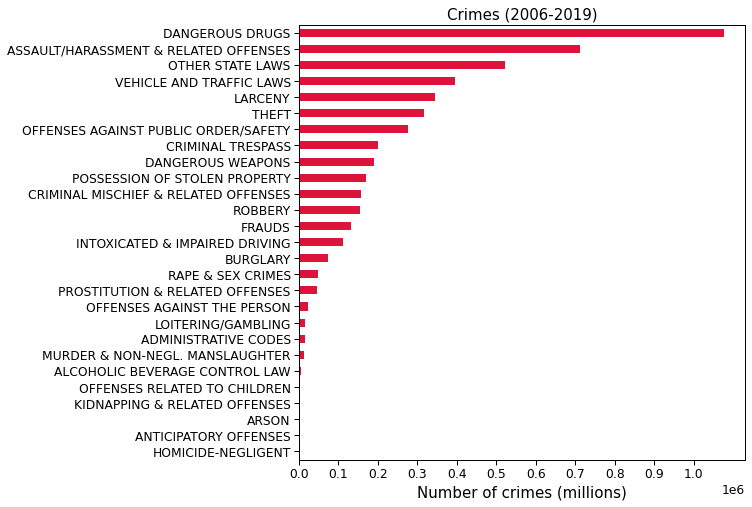

In [76]:
crime_plot = plt.figure(figsize = (8, 8))
crime_plot = crimes.Crime.value_counts().sort_values().plot(kind = 'barh', color = 'crimson')
plt.title("Crimes (2006-2019)", fontsize = 15)
plt.xlabel("Number of crimes (millions)", fontsize = 15)
plt.xticks(np.arange(0, 1100000, 100000))
plt.show()

### 3.2 - Crimes in Each Borough

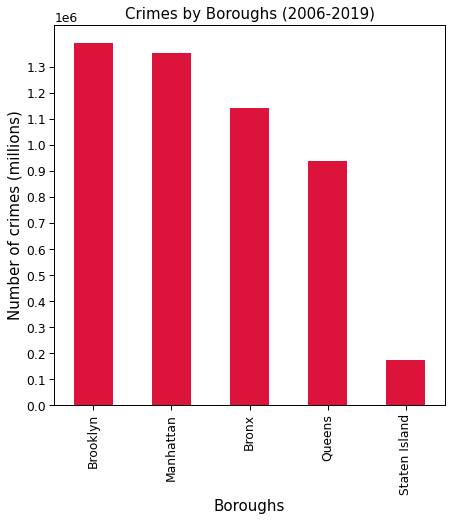

In [77]:
crime_borough = plt.figure(figsize = (7, 7))
crime_borough = crimes.Borough.value_counts().plot(kind = 'bar', color = 'crimson')
plt.title("Crimes by Boroughs (2006-2019)", fontsize = 15)
plt.ylabel("Number of crimes (millions)", fontsize = 15)
plt.xlabel("Boroughs", fontsize = 15)
plt.yticks(np.arange(0, 1400000, 100000))
plt.show()

### 3.3 - Genders

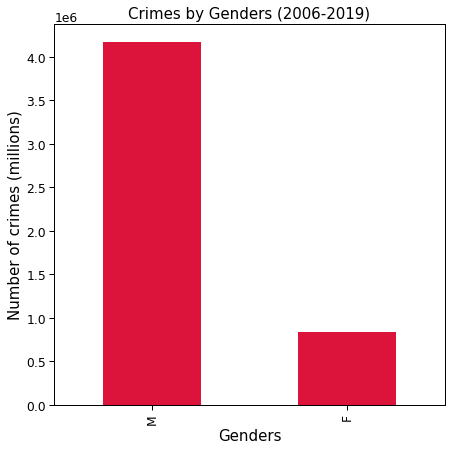

In [78]:
crime_perp_gender = plt.figure(figsize = (7,7))
crime_perp_gender = crimes.Perp_Gender.value_counts().plot(kind = 'bar', color = 'crimson')
plt.title("Crimes by Genders (2006-2019)", fontsize = 15)
plt.ylabel("Number of crimes (millions)", fontsize = 15)
plt.xlabel("Genders", fontsize = 15)
plt.yticks(np.arange(0, 4200000, 500000))
plt.show()

### 3.4 - Races

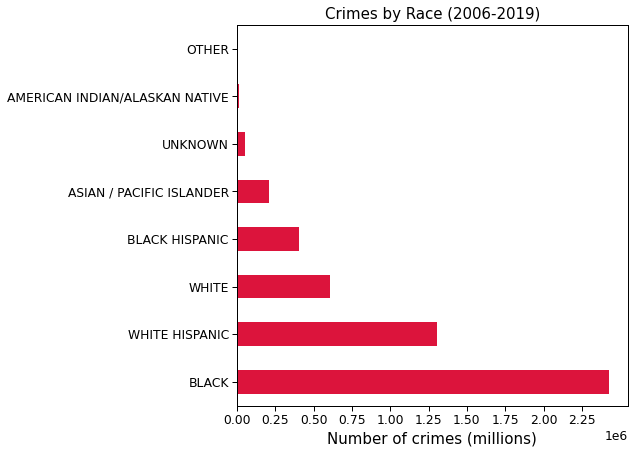

In [79]:
crime_perp_race = plt.figure(figsize = (7,7))
crime_perp_race = crimes.Perp_Race.value_counts().plot(kind = 'barh', color = 'crimson')
plt.title("Crimes by Race (2006-2019)", fontsize = 15)
plt.xlabel("Number of crimes (millions)", fontsize = 15)
plt.xticks(np.arange(0, 2500000, 250000))
plt.show()

### 3.5 - Total Number of Crimes by Year

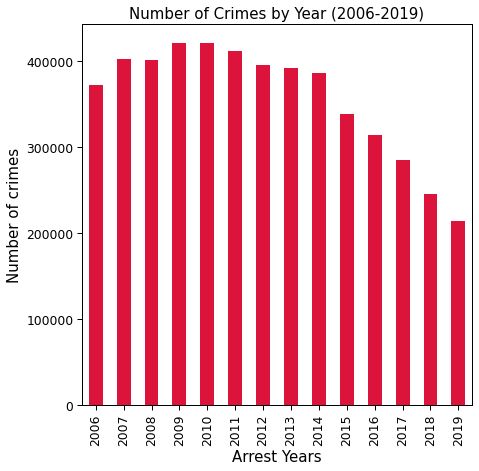

In [80]:
crimes_number_by_year = plt.figure(figsize = (7,7))
crimes_number_by_year = crimes.groupby(crimes.index.year).count()['Crime'].plot(kind='bar', color = 'crimson')
plt.title("Number of Crimes by Year (2006-2019)", fontsize = 15)
plt.ylabel("Number of crimes", fontsize = 15)
plt.xlabel("Arrest Years", fontsize = 15)
plt.yticks(np.arange(0, 500000, 100000))
plt.show()

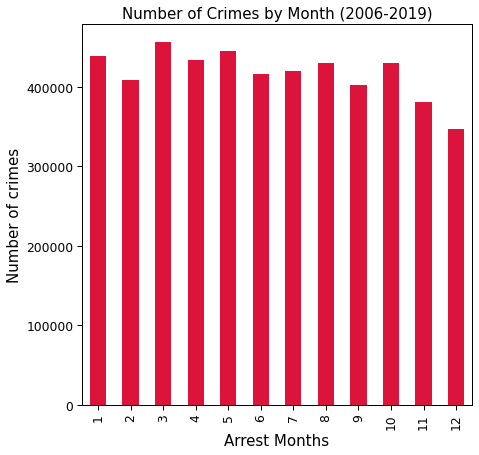

In [81]:
crimes_number_by_month = plt.figure(figsize = (7,7))
crimes_number_by_month = crimes.groupby(crimes.index.month).count()['Crime'].plot(kind='bar', color = 'crimson')
plt.title("Number of Crimes by Month (2006-2019)", fontsize = 15)
plt.ylabel("Number of crimes", fontsize = 15)
plt.xlabel("Arrest Months", fontsize = 15)
plt.yticks(np.arange(0, 500000, 100000))
plt.show()

### 3.6 - Crimes in Each Borough by Year

<function matplotlib.pyplot.show(close=None, block=None)>

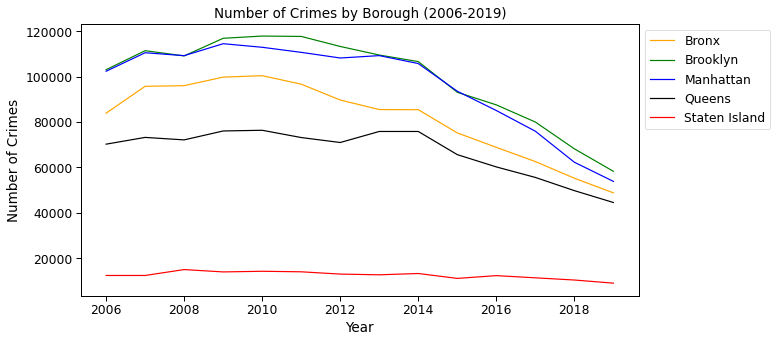

In [82]:
crimes_borough_year = crimes.groupby(['Borough', crimes.index.year]).count()['Crime']
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(crimes_borough_year.loc['Bronx'], color='orange', label='Bronx')
plt.plot(crimes_borough_year.loc['Brooklyn'], color='green', label='Brooklyn')
plt.plot(crimes_borough_year.loc['Manhattan'], color='blue', label='Manhattan')
plt.plot(crimes_borough_year.loc['Queens'], color='black', label='Queens')
plt.plot(crimes_borough_year.loc['Staten Island'], color='red', label='Staten Island')
plt.legend(bbox_to_anchor=(1, 1), loc='best')
plt.title('Number of Crimes by Borough (2006-2019)')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.show

### 3.7 - Education Attainment: Less than High School Degree

<function matplotlib.pyplot.show(close=None, block=None)>

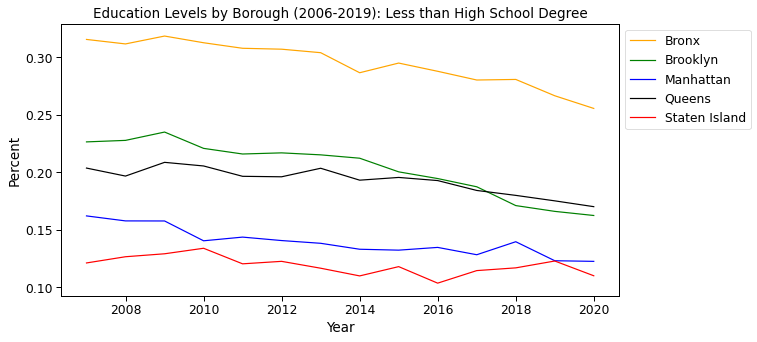

In [83]:
education_copy = education.copy()
less_than_hs = education_copy[education_copy['Education_Level'].str.contains('Less')]
less_than_hs = less_than_hs.drop(['Education_Level'], axis = 1)
less_than_hs = less_than_hs.groupby(['Borough'], as_index = True).resample('a').sum()
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(less_than_hs.loc['Bronx'], color='orange', label='Bronx')
plt.plot(less_than_hs.loc['Brooklyn'], color='green', label='Brooklyn')
plt.plot(less_than_hs.loc['Manhattan'], color='blue', label='Manhattan')
plt.plot(less_than_hs.loc['Queens'], color='black', label='Queens')
plt.plot(less_than_hs.loc['Staten Island'], color='red', label='Staten Island')
plt.legend(bbox_to_anchor=(1, 1), loc='best')
plt.title('Education Levels by Borough (2006-2019): Less than High School Degree')
plt.xlabel('Year')
plt.ylabel('Percent')
plt.show

### 3.8 - Education Attainment: High School Degree

<function matplotlib.pyplot.show(close=None, block=None)>

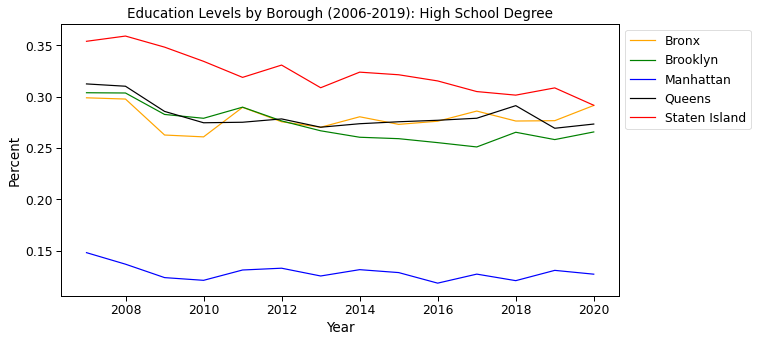

In [84]:
hs = education_copy[education_copy['Education_Level'].str.contains('School')]
hs = hs[hs.Education_Level != 'Less than High School Degree']
hs = hs.drop(['Education_Level'], axis = 1)
hs = hs.groupby(['Borough'], as_index = True).resample('a').sum()
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(hs.loc['Bronx'], color='orange', label='Bronx')
plt.plot(hs.loc['Brooklyn'], color='green', label='Brooklyn')
plt.plot(hs.loc['Manhattan'], color='blue', label='Manhattan')
plt.plot(hs.loc['Queens'], color='black', label='Queens')
plt.plot(hs.loc['Staten Island'], color='red', label='Staten Island')
plt.legend(bbox_to_anchor=(1, 1), loc='best')
plt.title('Education Levels by Borough (2006-2019): High School Degree')
plt.xlabel('Year')
plt.ylabel('Percent')
plt.show

### 3.9 - Education Attainment: Some College

<function matplotlib.pyplot.show(close=None, block=None)>

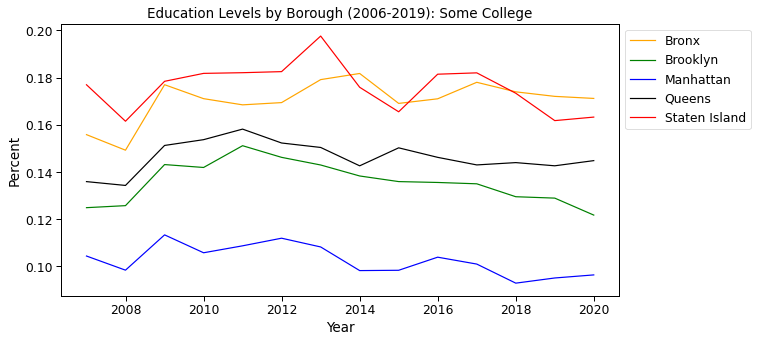

In [85]:
some_college = education_copy[education_copy['Education_Level'].str.contains('Some')]
some_college = some_college.drop(['Education_Level'], axis = 1)
some_college = some_college.groupby(['Borough'], as_index = True).resample('a').sum()
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(some_college.loc['Bronx'], color='orange', label='Bronx')
plt.plot(some_college.loc['Brooklyn'], color='green', label='Brooklyn')
plt.plot(some_college.loc['Manhattan'], color='blue', label='Manhattan')
plt.plot(some_college.loc['Queens'], color='black', label='Queens')
plt.plot(some_college.loc['Staten Island'], color='red', label='Staten Island')
plt.legend(bbox_to_anchor=(1, 1), loc='best')
plt.title('Education Levels by Borough (2006-2019): Some College')
plt.xlabel('Year')
plt.ylabel('Percent')
plt.show

### 3.10 - Education Attainment: Associate's Degree

<function matplotlib.pyplot.show(close=None, block=None)>

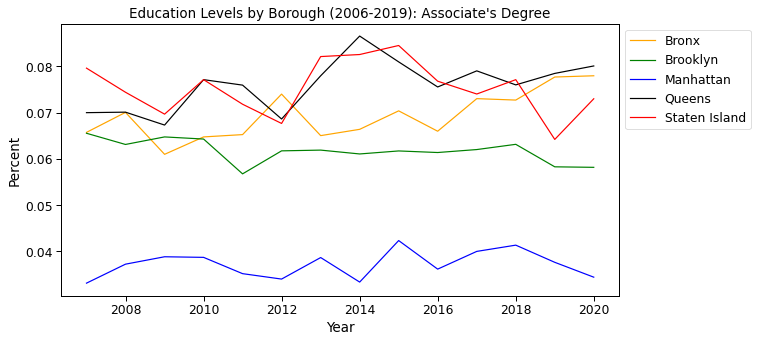

In [86]:
associates = education_copy[education_copy['Education_Level'].str.contains('Associate')]
associates = associates.drop(['Education_Level'], axis = 1)
associates = associates.groupby(['Borough'], as_index = True).resample('a').sum()
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(associates.loc['Bronx'], color='orange', label='Bronx')
plt.plot(associates.loc['Brooklyn'], color='green', label='Brooklyn')
plt.plot(associates.loc['Manhattan'], color='blue', label='Manhattan')
plt.plot(associates.loc['Queens'], color='black', label='Queens')
plt.plot(associates.loc['Staten Island'], color='red', label='Staten Island')
plt.legend(bbox_to_anchor=(1, 1), loc='best')
plt.title("Education Levels by Borough (2006-2019): Associate's Degree")
plt.xlabel('Year')
plt.ylabel('Percent')
plt.show

### 3.11 - Education Attainment: Bachelor's Degree or Higher

<function matplotlib.pyplot.show(close=None, block=None)>

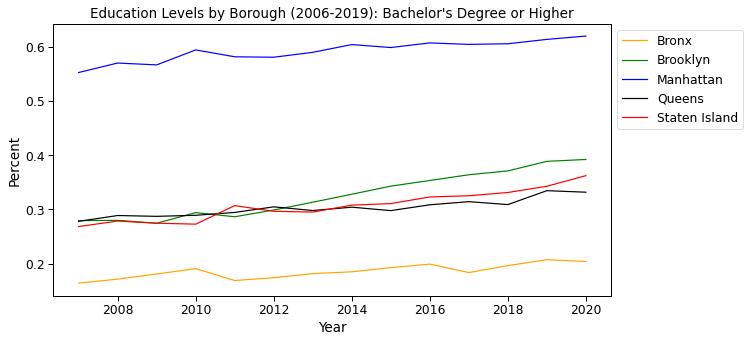

In [87]:
bachelor = education_copy[education_copy['Education_Level'].str.contains('Bachelor')]
bachelor = bachelor.drop(['Education_Level'], axis = 1)
bachelor = bachelor.groupby(['Borough'], as_index = True).resample('a').sum()
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(bachelor.loc['Bronx'], color='orange', label='Bronx')
plt.plot(bachelor.loc['Brooklyn'], color='green', label='Brooklyn')
plt.plot(bachelor.loc['Manhattan'], color='blue', label='Manhattan')
plt.plot(bachelor.loc['Queens'], color='black', label='Queens')
plt.plot(bachelor.loc['Staten Island'], color='red', label='Staten Island')
plt.legend(bbox_to_anchor=(1, 1), loc='best')
plt.title("Education Levels by Borough (2006-2019): Bachelor's Degree or Higher")
plt.xlabel('Year')
plt.ylabel('Percent')
plt.show

### 3.12 - Median Household Income

<function matplotlib.pyplot.show(close=None, block=None)>

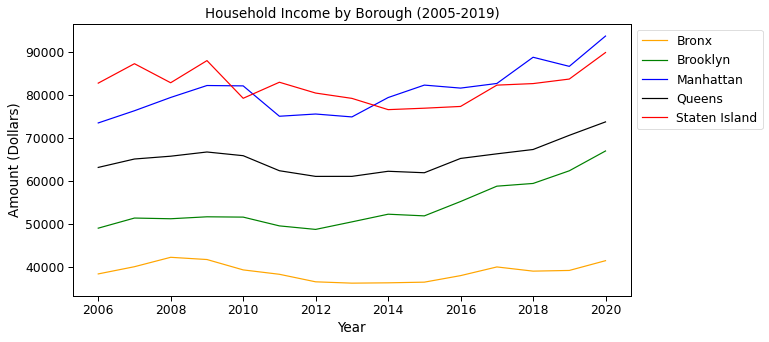

In [88]:
income_copy = income.copy()
income_grouped = income_copy.groupby(['Borough'], as_index = True).resample('a').sum()
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(income_grouped.loc['Bronx'], color='orange', label='Bronx')
plt.plot(income_grouped.loc['Brooklyn'], color='green', label='Brooklyn')
plt.plot(income_grouped.loc['Manhattan'], color='blue', label='Manhattan')
plt.plot(income_grouped.loc['Queens'], color='black', label='Queens')
plt.plot(income_grouped.loc['Staten Island'], color='red', label='Staten Island')
plt.legend(bbox_to_anchor=(1, 1), loc='best')
plt.title('Household Income by Borough (2005-2019)')
plt.xlabel('Year')
plt.ylabel('Amount (Dollars)')
plt.show

### 3.13 - Unemployment Rate

<function matplotlib.pyplot.show(close=None, block=None)>

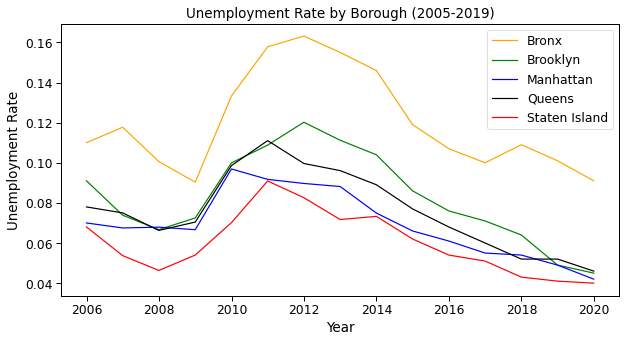

In [89]:
unemployment_copy = unemployment.copy()
unemployment_grouped = unemployment_copy.groupby(['Borough'], as_index = True).resample('a').sum()
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(unemployment_grouped.loc['Bronx'], color='orange', label='Bronx')
plt.plot(unemployment_grouped.loc['Brooklyn'], color='green', label='Brooklyn')
plt.plot(unemployment_grouped.loc['Manhattan'], color='blue', label='Manhattan')
plt.plot(unemployment_grouped.loc['Queens'], color='black', label='Queens')
plt.plot(unemployment_grouped.loc['Staten Island'], color='red', label='Staten Island')
plt.legend(bbox_to_anchor=(1, 1), loc='best')
plt.title('Unemployment Rate by Borough (2005-2019)')
plt.xlabel('Year')
plt.ylabel('Unemployment Rate')
plt.show

## 4. Analysis and Modeling: SARIMAX

### 4.1 - Preparing Data

In [90]:
# make a copy of crimes dataset
crimes_copy = crimes.copy()
crimes_copy.head()

,Crime,Borough,Perp_Gender,Perp_Race
Arrest_Date,,,,
2018-11-07,OTHER STATE LAWS,Manhattan,M,WHITE
2018-11-15,ASSAULT/HARASSMENT & RELATED OFFENSES,Bronx,M,BLACK
2018-11-07,RAPE & SEX CRIMES,Bronx,M,BLACK
2018-10-22,ASSAULT/HARASSMENT & RELATED OFFENSES,Brooklyn,M,BLACK
2009-09-17,RAPE & SEX CRIMES,Staten Island,M,BLACK HISPANIC


In [91]:
# drop columns
crimes_copy = crimes_copy.drop(['Perp_Gender','Perp_Race'], axis = 1)
# count number of crimes by borough
crimes_copy = crimes_copy.groupby(['Borough'], as_index = True).resample('M').agg({"Crime":'size'})
# rename crime column
crimes_copy.rename(columns = {'Crime':'Crime_Number'}, inplace = True)
# view data
crimes_copy.head()

Crime_Number
Borough Arrest_Date              
Bronx   2006-01-31           7336
        2006-02-28           6597
        2006-03-31           7852
        2006-04-30           6718
        2006-05-31           7176

### 4.2 - Functions

In [92]:
# stationarity check with Dickey-Fuller test

def stationarity_check(ts):
    
    '''Enter time series dataframe to get results of Dickey-Fuller Test and see if the original time series is stationary'''
    
    dftest = adfuller(ts.dropna())
    print('\nResults of Dickey-Fuller Test: \n')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [93]:
# decompose time series so we can observe trend, seasionality, and residuals

def decomposition(ts):
    
    '''This function decomposes time series so we can observe trend, seasonality, and residual plots'''
    
    decomposition = seasonal_decompose(ts)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    plt.figure(figsize=(10,7))
    plt.subplot(511)
    plt.plot(ts, label='Original', color='blue')
    plt.legend(loc='best')
    plt.subplot(512)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    plt.subplot(513)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')
    plt.subplot(514)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    plt.tight_layout()

In [94]:
# calculates the residual in order to do stationary test
def residual(ts):
    
    '''This function calculate the residuals to do the stationary test in case the original data is not stationary'''
    
    decomposition = seasonal_decompose(ts)
    residual = decomposition.resid
    residual.dropna(inplace=True)
    return residual

In [95]:
# run auto arima and search for the best parameters and then using SARIMAX to fit our models

def best_parameters(ts):
    
    '''Enter time series. This function will let auto_arima search for hyperparameters, then SARIMAX will fit these 
    hyperparameters to get the best model with lowest AIC'''
    
    best_orders = pm.auto_arima(ts, start_p = 0, start_q = 0, max_p = 2, max_q = 2, m = 12, seasonal = True, 
                                   stationary = False, stepwise = True, trend = 'ct', suppress_warnings = True, 
                                   trace = False, error_action = 'ignore')
    best_model = SARIMAX(ts, order = best_orders.order, seasonal_order = best_orders.seasonal_order).fit()
    best_parameters = []
    best_parameters.append([best_orders.order, best_orders.seasonal_order, best_model.aic]) 
    print('ARIMA {} x {}, AIC Calculated: {}'.format(best_orders.order, best_orders.seasonal_order, best_model.aic))
    print(best_model.summary())
    return best_model

In [96]:
# get predictions for the best model
def get_predictions(ts, model, steps = 84, plot=True, show=True):
    
    '''Parameters: time series dataframe, model, steps, plot, and show.
    This function gets one-step-ahead forecast and compares it to the actual points.
    In addition, it also makes future predictions for the number of steps passed as parameters, plot results with 95% confidence
    interval, and calculates RMSE & percentage change'''
    
    # Get preditions from model for the last 3 years of data period
    pred = model.get_prediction(start='2017-01-31', dynamic=False)
    conf = pred.conf_int()

    # Plot observed and predicted values with confidence interval
    if plot:
        ax = ts['2006':].plot(label='Observed', figsize=(10, 8))
        pred.predicted_mean.plot(ax=ax, label='One-step-ahead Forecast', alpha=.5)
        ax.fill_between(conf.index,
                        conf.iloc[:, 0],
                        conf.iloc[:, 1], color='g', alpha=.3,
                        label='Confidence Interval')
        ax.set_ylabel('Value')
        ax.set_xlabel('Year')
        plt.title('Observations vs Predictions')
        ax.legend()
        plt.show()
        
    # Compare real and predicted values to validade model and compute the rmse
    predicted = pred.predicted_mean
    real = ts['2017-01-31':].Crime_Number
    mse = np.square(np.subtract(real,predicted)).mean()
    rmse = math.sqrt(mse)
        
    # Get forecast and confidence interval for steps ahead in future
    future = model.get_forecast(steps=steps, dynamic=True)
    future_conf = future.conf_int()

    # Plot future forecast with confidence interval
    if plot:
        ax = ts['2006':].plot(label='Observed', figsize=(10, 8))
        future.predicted_mean.plot(ax=ax, label='Forecast')
        ax.fill_between(future_conf.index,
                        future_conf.iloc[:, 0],
                        future_conf.iloc[:, 1], color='g', alpha=.3)
        ax.fill_betweenx(ax.get_ylim(), 
                         pd.to_datetime('2026-12-31'), 
                         predicted.index[-1], alpha=.1, zorder=-1)
        ax.set_xlabel('Year')
        ax.set_ylabel('Number of Crimes')
        plt.title('Future Forecast')
        ax.legend()
        plt.show()
        
    # show prediction for end of step-period 
    forecast = future.predicted_mean[-1]
    upper = future_conf.iloc[-1,1]
    lower = future_conf.iloc[-1,0]
    predictions = {}
    predictions['Upper Bound'] = upper
    predictions['Expected Forecast'] = forecast
    predictions['Lower Bound'] = lower
    predictions = pd.DataFrame.from_dict(predictions, orient='index', columns=['Prediction'])
  
    # calculate return percentages
    crime_2019 = ts.loc['2019-12-31']
    forecast_2026 = forecast
    forecast_lower = lower
    forecast_upper = upper
    return_percentage_predictions = {}
    predicted_percent_change = ((forecast_2026- crime_2019) / crime_2019)*100
    upper_percent_change = ((forecast_upper - crime_2019) / crime_2019)*100
    lower_percent_change = ((forecast_lower - crime_2019) / crime_2019)*100
    return_percentage_predictions['Predicted % Change'] = predicted_percent_change
    return_percentage_predictions['Upper % Change'] = upper_percent_change
    return_percentage_predictions['Lower % Change'] = lower_percent_change
    return_percentage_predictions = pd.DataFrame.from_dict(return_percentage_predictions,orient='index')
    
    if show:
        print(predictions)
        
        print('\n' + f'The RMSE of our forecast is {round(rmse, 2)}' + '\n')
        
        print(return_percentage_predictions)

### 4.3 - Bronx

In [97]:
bronx_crimes = crimes_copy.loc['Bronx']
bronx_crimes

,Crime_Number
Arrest_Date,
2006-01-31,7336
2006-02-28,6597
2006-03-31,7852
2006-04-30,6718
2006-05-31,7176
2006-06-30,6558
2006-07-31,6838
2006-08-31,7291
2006-09-30,6880


In [98]:
bronx_stationarity_check = stationarity_check(bronx_crimes)


Results of Dickey-Fuller Test: 

Test Statistic                   1.651292
p-value                          0.998004
#Lags Used                      12.000000
Number of Observations Used    155.000000
Critical Value (1%)             -3.473259
Critical Value (5%)             -2.880374
Critical Value (10%)            -2.576812
dtype: float64


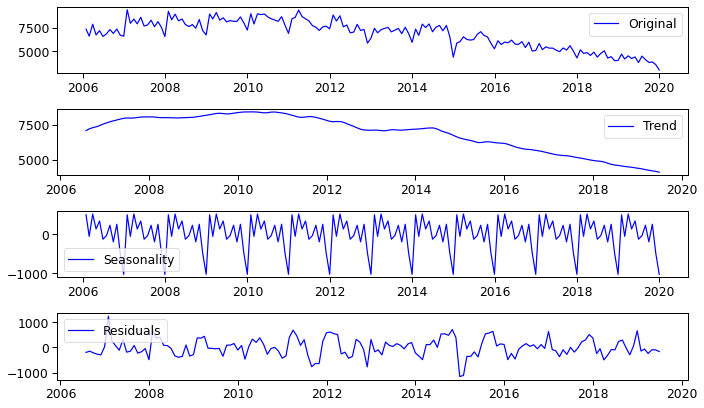

In [99]:
bronx_decomposition = decomposition(bronx_crimes)

In [100]:
bronx_residual_stationarity_check = stationarity_check(residual(bronx_crimes))


Results of Dickey-Fuller Test: 

Test Statistic                -7.276929e+00
p-value                        1.535763e-10
#Lags Used                     1.000000e+01
Number of Observations Used    1.450000e+02
Critical Value (1%)           -3.476273e+00
Critical Value (5%)           -2.881688e+00
Critical Value (10%)          -2.577513e+00
dtype: float64


In [101]:
best_bronx = best_parameters(bronx_crimes)

ARIMA (1, 1, 1) x (1, 0, 1, 12), AIC Calculated: 2491.9770636299236
                                     SARIMAX Results                                      
Dep. Variable:                       Crime_Number   No. Observations:                  168
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1240.989
Date:                            Sat, 29 May 2021   AIC                           2491.977
Time:                                    10:09:30   BIC                           2507.567
Sample:                                01-31-2006   HQIC                          2498.305
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9339      0.038     24.658   

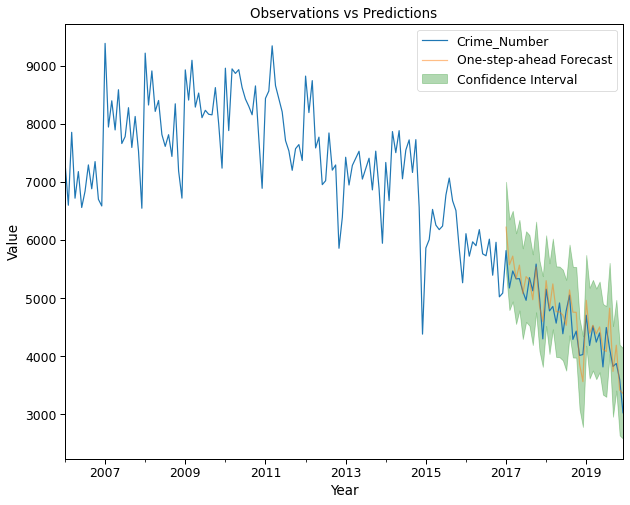

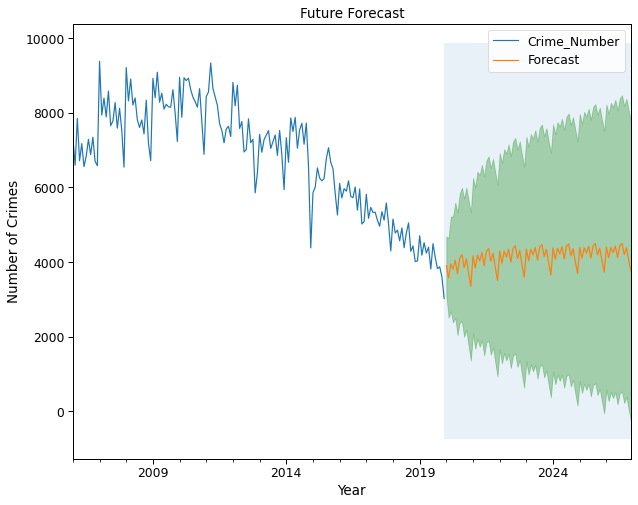

                    Prediction
Upper Bound        7777.087804
Expected Forecast  3758.806869
Lower Bound        -259.474067

The RMSE of our forecast is 282.42

                    Crime_Number
Lower % Change       -108.580492
Predicted % Change     24.299169
Upper % Change        157.178830


In [102]:
forecast_bronx_crimes = get_predictions(bronx_crimes, best_bronx, steps=84, plot=True, show=True)

### 4.4 - Brooklyn

In [103]:
brooklyn_crimes = crimes_copy.loc['Brooklyn']
brooklyn_crimes

,Crime_Number
Arrest_Date,
2006-01-31,8478
2006-02-28,7988
2006-03-31,9418
2006-04-30,8602
2006-05-31,8836
2006-06-30,8698
2006-07-31,8388
2006-08-31,9012
2006-09-30,8438


In [104]:
brooklyn_stationarity_check = stationarity_check(brooklyn_crimes)


Results of Dickey-Fuller Test: 

Test Statistic                   2.342033
p-value                          0.998980
#Lags Used                      12.000000
Number of Observations Used    155.000000
Critical Value (1%)             -3.473259
Critical Value (5%)             -2.880374
Critical Value (10%)            -2.576812
dtype: float64


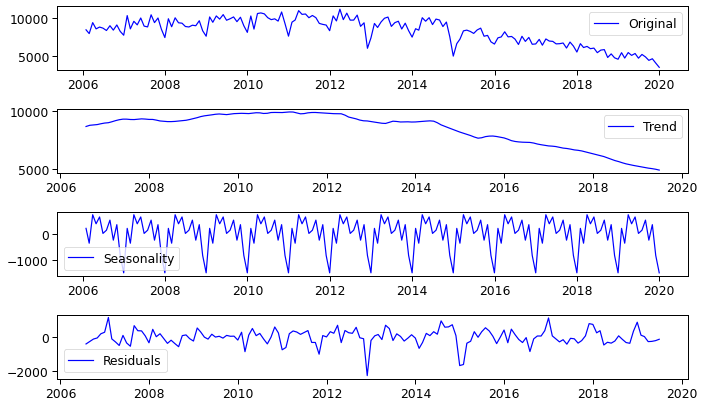

In [105]:
brooklyn_decomposition = decomposition(brooklyn_crimes)

In [106]:
brooklyn_residual_stationarity_check = stationarity_check(residual(brooklyn_crimes))


Results of Dickey-Fuller Test: 

Test Statistic                -7.154920e+00
p-value                        3.072419e-10
#Lags Used                     1.000000e+01
Number of Observations Used    1.450000e+02
Critical Value (1%)           -3.476273e+00
Critical Value (5%)           -2.881688e+00
Critical Value (10%)          -2.577513e+00
dtype: float64


In [107]:
best_brooklyn = best_parameters(brooklyn_crimes)

ARIMA (2, 1, 0) x (1, 0, 1, 12), AIC Calculated: 2594.227459659013
                                      SARIMAX Results                                       
Dep. Variable:                         Crime_Number   No. Observations:                  168
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -1292.114
Date:                              Sat, 29 May 2021   AIC                           2594.227
Time:                                      10:10:56   BIC                           2609.817
Sample:                                  01-31-2006   HQIC                          2600.555
                                       - 12-31-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3027      0.05

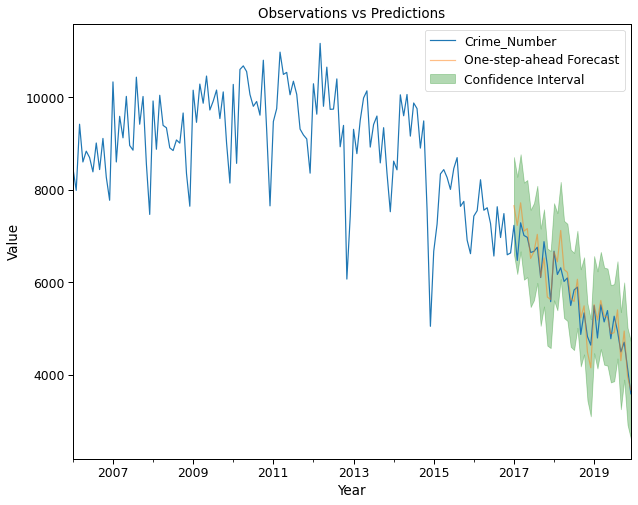

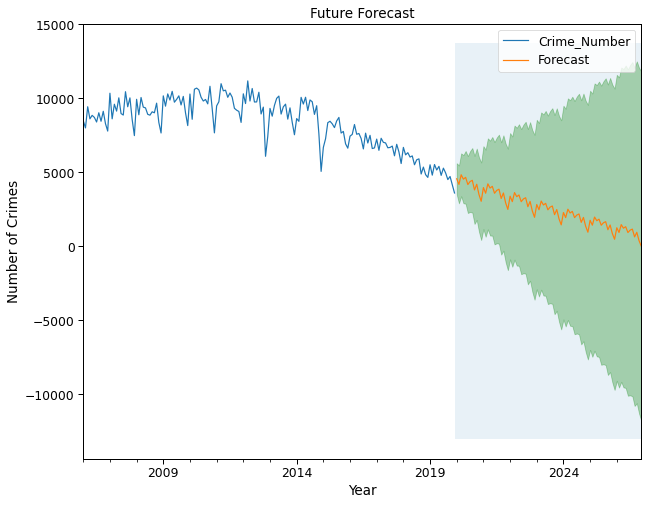

                     Prediction
Upper Bound        11808.643877
Expected Forecast      0.688706
Lower Bound       -11807.266464

The RMSE of our forecast is 323.85

                    Crime_Number
Lower % Change       -428.984856
Predicted % Change    -99.980811
Upper % Change        229.023234


In [108]:
forecast_brooklyn_crimes = get_predictions(brooklyn_crimes, best_brooklyn, steps=84, plot=True, show=True)

### 4.5 - Manhattan

In [109]:
manhattan_crimes = crimes_copy.loc['Manhattan']
manhattan_crimes

,Crime_Number
Arrest_Date,
2006-01-31,8322
2006-02-28,7973
2006-03-31,9165
2006-04-30,8302
2006-05-31,8671
2006-06-30,8430
2006-07-31,8475
2006-08-31,9040
2006-09-30,8555


In [110]:
manhattan_stationarity_check = stationarity_check(manhattan_crimes)


Results of Dickey-Fuller Test: 

Test Statistic                   2.146042
p-value                          0.998835
#Lags Used                      14.000000
Number of Observations Used    153.000000
Critical Value (1%)             -3.473830
Critical Value (5%)             -2.880623
Critical Value (10%)            -2.576945
dtype: float64


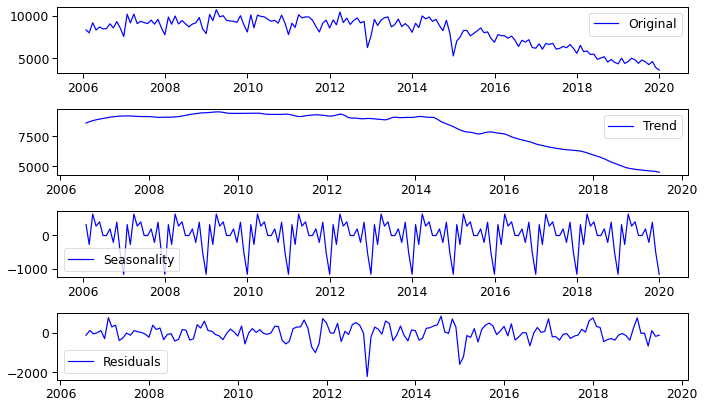

In [111]:
manhattan_decomposition = decomposition(manhattan_crimes)

In [112]:
manhattan_residual_stationarity_check = stationarity_check(residual(manhattan_crimes))


Results of Dickey-Fuller Test: 

Test Statistic                -7.378870e+00
p-value                        8.577308e-11
#Lags Used                     1.000000e+01
Number of Observations Used    1.450000e+02
Critical Value (1%)           -3.476273e+00
Critical Value (5%)           -2.881688e+00
Critical Value (10%)          -2.577513e+00
dtype: float64


In [113]:
best_manhattan = best_parameters(manhattan_crimes)

ARIMA (2, 1, 0) x (1, 0, 1, 12), AIC Calculated: 2569.810844076288
                                      SARIMAX Results                                       
Dep. Variable:                         Crime_Number   No. Observations:                  168
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -1279.905
Date:                              Sat, 29 May 2021   AIC                           2569.811
Time:                                      10:12:21   BIC                           2585.401
Sample:                                  01-31-2006   HQIC                          2576.138
                                       - 12-31-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2606      0.05

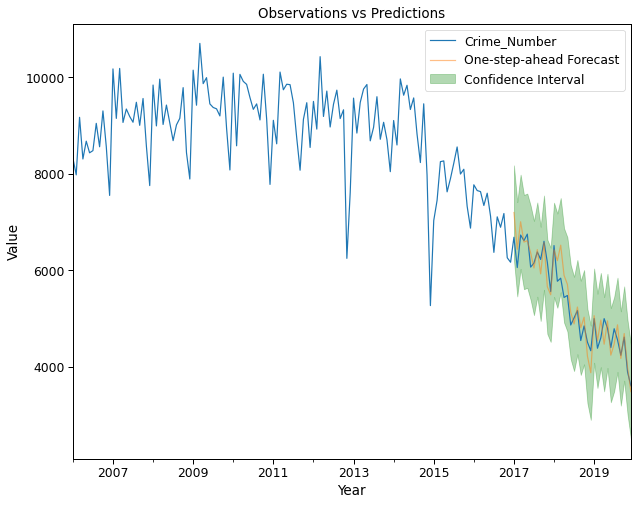

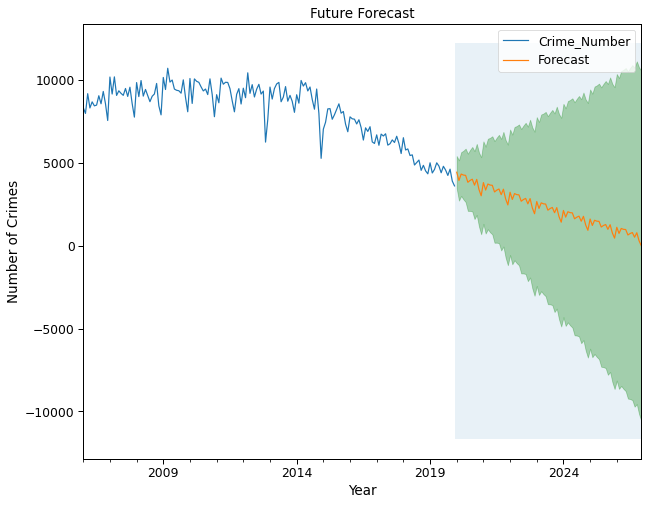

                     Prediction
Upper Bound        10562.561204
Expected Forecast     -0.322182
Lower Bound       -10563.205569

The RMSE of our forecast is 292.56

                    Crime_Number
Lower % Change       -393.259455
Predicted % Change   -100.008945
Upper % Change        193.241566


In [114]:
forecast_manhattan_crimes = get_predictions(manhattan_crimes, best_manhattan, steps=84, plot=True, show=True)

### 4.6 - Queens

In [115]:
queens_crimes = crimes_copy.loc['Queens']
queens_crimes

,Crime_Number
Arrest_Date,
2006-01-31,6026
2006-02-28,5538
2006-03-31,6554
2006-04-30,5969
2006-05-31,6497
2006-06-30,5723
2006-07-31,5644
2006-08-31,5766
2006-09-30,5591


In [116]:
queens_stationarity_check = stationarity_check(queens_crimes)


Results of Dickey-Fuller Test: 

Test Statistic                   1.469746
p-value                          0.997409
#Lags Used                      12.000000
Number of Observations Used    155.000000
Critical Value (1%)             -3.473259
Critical Value (5%)             -2.880374
Critical Value (10%)            -2.576812
dtype: float64


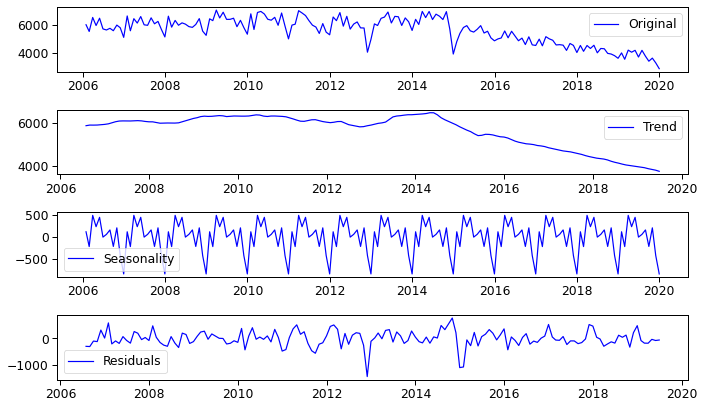

In [117]:
queens_decomposition = decomposition(queens_crimes)

In [118]:
queens_residual_stationarity_check = stationarity_check(residual(queens_crimes))


Results of Dickey-Fuller Test: 

Test Statistic                -6.601238e+00
p-value                        6.727621e-09
#Lags Used                     1.100000e+01
Number of Observations Used    1.440000e+02
Critical Value (1%)           -3.476598e+00
Critical Value (5%)           -2.881829e+00
Critical Value (10%)          -2.577589e+00
dtype: float64


In [119]:
best_queens = best_parameters(queens_crimes)

ARIMA (2, 1, 0) x (1, 0, 1, 12), AIC Calculated: 2457.597407740108
                                      SARIMAX Results                                       
Dep. Variable:                         Crime_Number   No. Observations:                  168
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -1223.799
Date:                              Sat, 29 May 2021   AIC                           2457.597
Time:                                      10:13:44   BIC                           2473.187
Sample:                                  01-31-2006   HQIC                          2463.925
                                       - 12-31-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3223      0.05

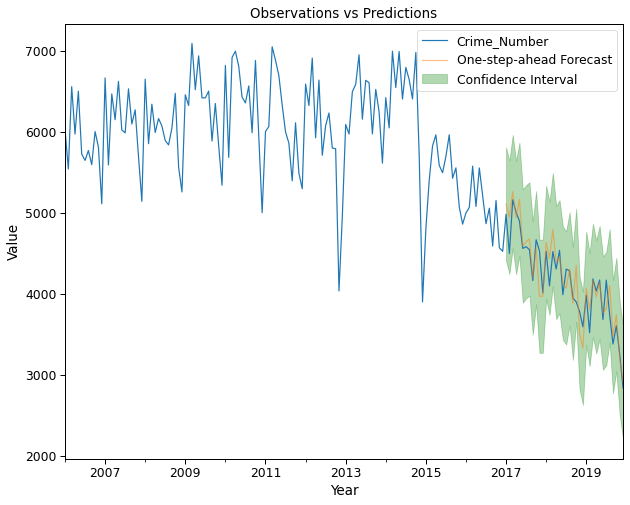

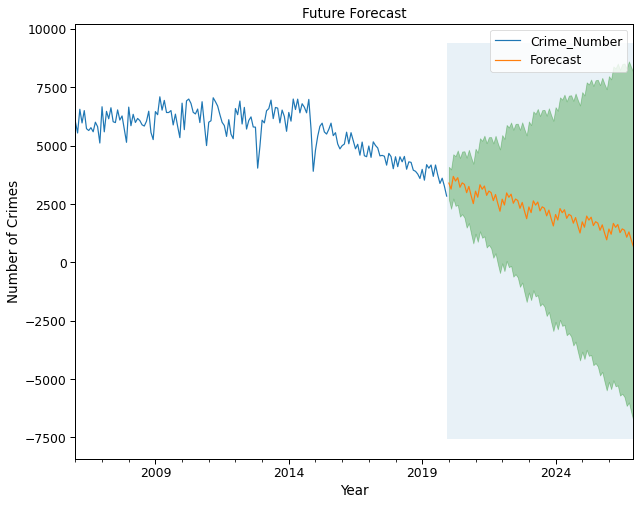

                    Prediction
Upper Bound        8139.508565
Expected Forecast   676.996126
Lower Bound       -6785.516313

The RMSE of our forecast is 215.85

                    Crime_Number
Lower % Change       -339.263622
Predicted % Change    -76.128486
Upper % Change        187.006649


In [120]:
forecast_queens_crimes = get_predictions(queens_crimes, best_queens, steps=84, plot=True, show=True)

### 4.7 - Staten Island

In [121]:
staten_crimes = crimes_copy.loc['Staten Island']
staten_crimes

,Crime_Number
Arrest_Date,
2006-01-31,989
2006-02-28,861
2006-03-31,1021
2006-04-30,1038
2006-05-31,1187
2006-06-30,1122
2006-07-31,1103
2006-08-31,1135
2006-09-30,991


In [122]:
staten_stationarity_check = stationarity_check(staten_crimes)


Results of Dickey-Fuller Test: 

Test Statistic                  -0.359881
p-value                          0.916585
#Lags Used                      12.000000
Number of Observations Used    155.000000
Critical Value (1%)             -3.473259
Critical Value (5%)             -2.880374
Critical Value (10%)            -2.576812
dtype: float64


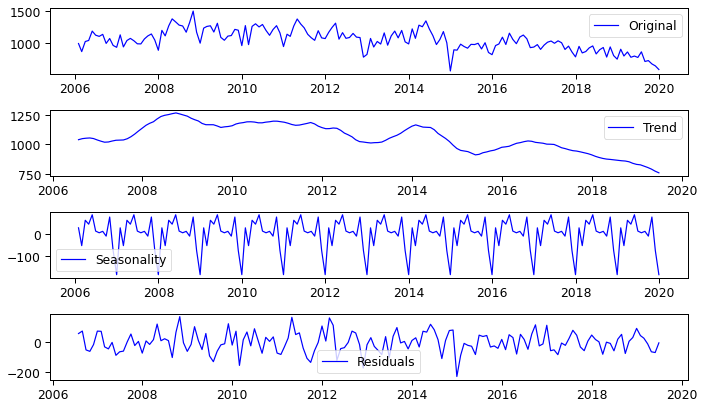

In [123]:
staten_decomposition = decomposition(staten_crimes)

In [124]:
staten_residual_stationarity_check = stationarity_check(residual(staten_crimes))


Results of Dickey-Fuller Test: 

Test Statistic                -7.957537e+00
p-value                        3.009102e-12
#Lags Used                     3.000000e+00
Number of Observations Used    1.520000e+02
Critical Value (1%)           -3.474121e+00
Critical Value (5%)           -2.880750e+00
Critical Value (10%)          -2.577013e+00
dtype: float64


In [125]:
best_staten = best_parameters(staten_crimes)

ARIMA (2, 1, 1) x (2, 0, 1, 12), AIC Calculated: 1994.135037429333
                                     SARIMAX Results                                      
Dep. Variable:                       Crime_Number   No. Observations:                  168
Model:             SARIMAX(2, 1, 1)x(2, 0, 1, 12)   Log Likelihood                -990.068
Date:                            Sat, 29 May 2021   AIC                           1994.135
Time:                                    10:15:58   BIC                           2015.961
Sample:                                01-31-2006   HQIC                          2002.994
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1723      0.191      0.900    

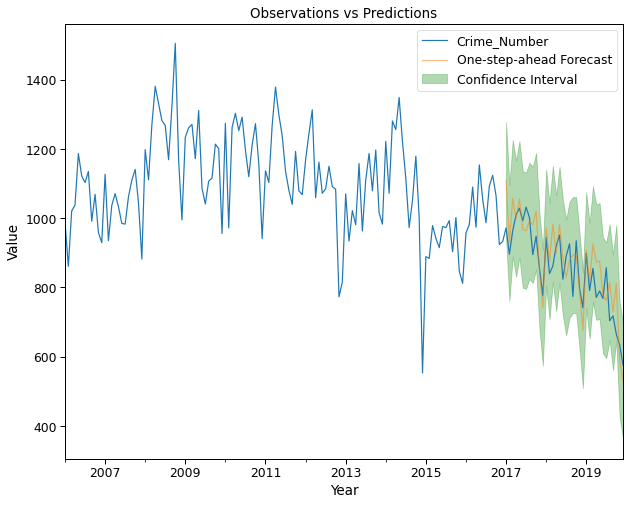

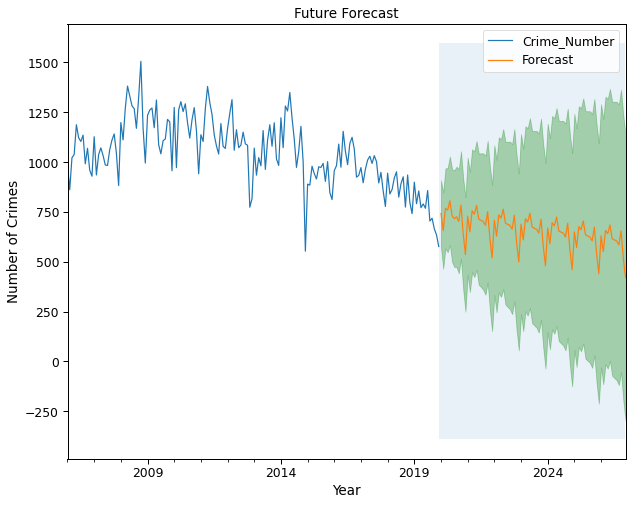

                    Prediction
Upper Bound        1140.217515
Expected Forecast   421.146034
Lower Bound        -297.925448

The RMSE of our forecast is 68.35

                    Crime_Number
Lower % Change       -151.723168
Predicted % Change    -26.884369
Upper % Change         97.954430


In [126]:
forecast_staten_crimes = get_predictions(staten_crimes, best_staten, steps=84, plot=True, show=True)

## 5. Analysis and Modeling: Facebook Prophet

### 5.1 - Functions

In [127]:
def plot_timeseries(ts):
    
    '''Enter time series dataframe to plot the original data points'''
    
    # Plot the timeseries 
    pd.plotting.register_matplotlib_converters()
    ax = ts.set_index('ds').plot(figsize=(10, 8))
    ax.set_ylabel('No. of Crimes')
    ax.set_xlabel('Year')
    plt.show()

In [128]:
def prophet_model(ts):
    
    '''Input time series data to get prediction with 95% confidence interval, fit the model, plot predictions, calculate 
    percentage change and RMSE'''

    
    # train-test split
    train_data = ts.iloc[:len(ts)-36]
    test_data = ts.iloc[len(ts)-36:]
    
    # Set the uncertainty interval to 95% and yearly seasonality
    model = Prophet(interval_width=0.95, yearly_seasonality = True, weekly_seasonality=True, daily_seasonality=True)
    # Fit the timeseries to model
    model.fit(train_data)
    # Use make_future_dataframe() with a monthly frequency and periods = 84 
    future = model.make_future_dataframe(periods=120, freq='M')
    # Predict the values for future dates and take the head of forecast
    forecast = model.predict(future)
    # Use Prophet's plot method to plot the predictions
    model.plot(forecast, uncertainty=True)
    plt.show()
    # Plot model components 
    model.plot_components(forecast)
    plt.show()
    # Calculate RMSE
    y_true = ts['y'].values
    y_pred = forecast['yhat'][:168].values
    RMSE = np.sqrt(mean_squared_error(y_true,y_pred))
    
    # show prediction for end of step-period 
    forecast_2026 = forecast['yhat'][251]
    forecast_lower = forecast['yhat_lower'][251]
    forecast_upper = forecast['yhat_upper'][251]
    print(f'Predicted Number of Crimes: {round(forecast_2026, 2)}' + '\n')
    print(f'Upper Number of Crimes: {round(forecast_upper, 2)}' + '\n')
    print(f'Lower Number of Crimes: {round(forecast_lower, 2)}' + '\n')
  
    # calculate return percentages
    crime_2019 = ts['y'][167]
    forecast_2026 = forecast['yhat'][251]
    forecast_lower = forecast['yhat_lower'][251]
    forecast_upper = forecast['yhat_upper'][251]
    return_percentage_predictions = {}
    predicted_percent_change = ((forecast_2026- crime_2019) / crime_2019)*100
    upper_percent_change = ((forecast_upper - crime_2019) / crime_2019)*100
    lower_percent_change = ((forecast_lower - crime_2019) / crime_2019)*100
    return_percentage_predictions['Predicted % Change'] = predicted_percent_change
    return_percentage_predictions['Upper % Change'] = upper_percent_change
    return_percentage_predictions['Lower % Change'] = lower_percent_change
    print(f'The RMSE of our forecast is {round(RMSE, 2)}' + '\n')
    print(f'Predicted % Change: {round(predicted_percent_change, 2)}' + '\n')
    print(f'Upper % Change: {round(upper_percent_change, 2)}' + '\n')
    print(f'Lower % Change: {round(lower_percent_change, 2)}' + '\n')

### 5.2 - Bronx

In [129]:
bronx_crimes_fb = crimes_copy.loc['Bronx']
bronx_crimes_fb = bronx_crimes_fb.reset_index()
bronx_crimes_fb = bronx_crimes_fb.rename(columns={'Arrest_Date': 'ds', 'Crime_Number': 'y'})
bronx_crimes_fb

,ds,y
0,2006-01-31,7336
1,2006-02-28,6597
2,2006-03-31,7852
3,2006-04-30,6718
4,2006-05-31,7176
5,2006-06-30,6558
6,2006-07-31,6838
7,2006-08-31,7291
8,2006-09-30,6880
9,2006-10-31,7348


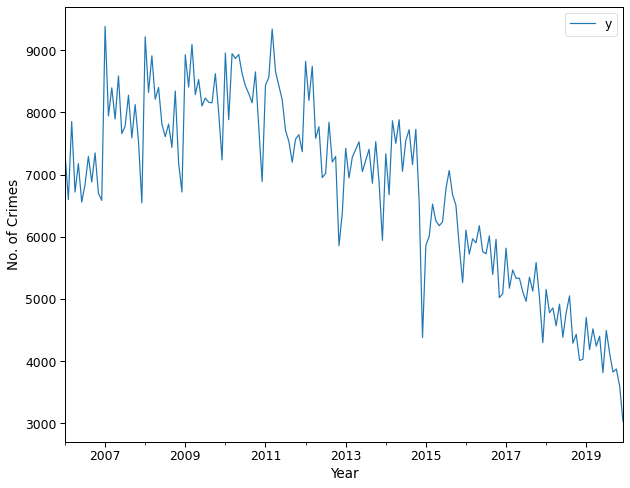

In [130]:
plot_timeseries(bronx_crimes_fb)

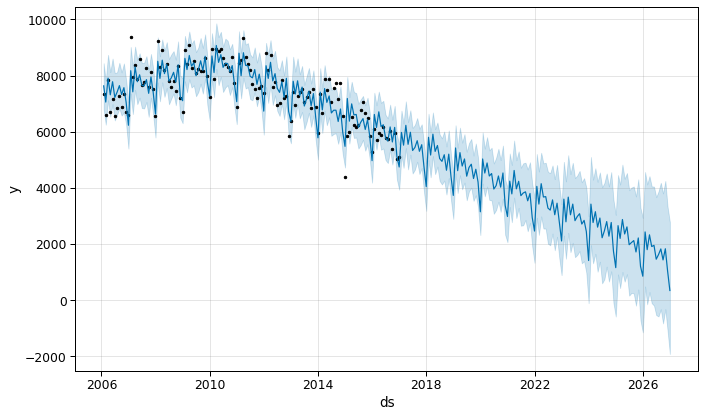

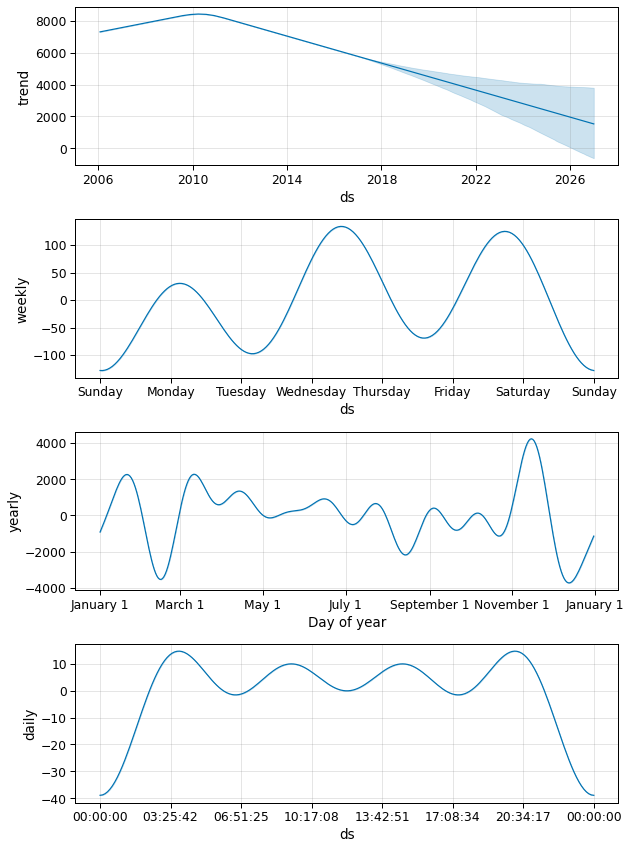

Predicted Number of Crimes: 345.1

Upper Number of Crimes: 2781.6

Lower Number of Crimes: -1915.85

The RMSE of our forecast is 439.06

Predicted % Change: -88.59

Upper % Change: -8.02

Lower % Change: -163.35



In [131]:
prophet_model(bronx_crimes_fb)

### 5.3 - Brooklyn

In [132]:
brooklyn_crimes_fb = crimes_copy.loc['Brooklyn']
brooklyn_crimes_fb = brooklyn_crimes_fb.reset_index()
brooklyn_crimes_fb = brooklyn_crimes_fb.rename(columns={'Arrest_Date': 'ds', 'Crime_Number': 'y'})
brooklyn_crimes_fb

,ds,y
0,2006-01-31,8478
1,2006-02-28,7988
2,2006-03-31,9418
3,2006-04-30,8602
4,2006-05-31,8836
5,2006-06-30,8698
6,2006-07-31,8388
7,2006-08-31,9012
8,2006-09-30,8438
9,2006-10-31,9111


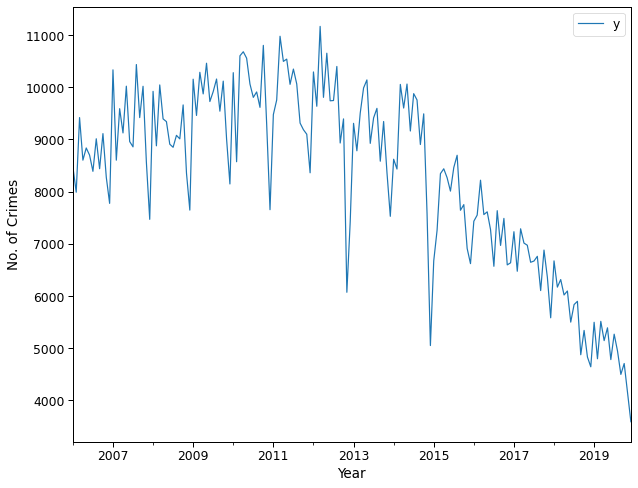

In [133]:
plot_timeseries(brooklyn_crimes_fb)

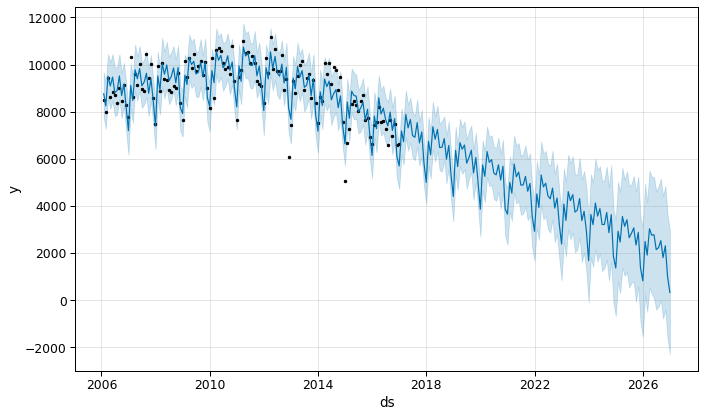

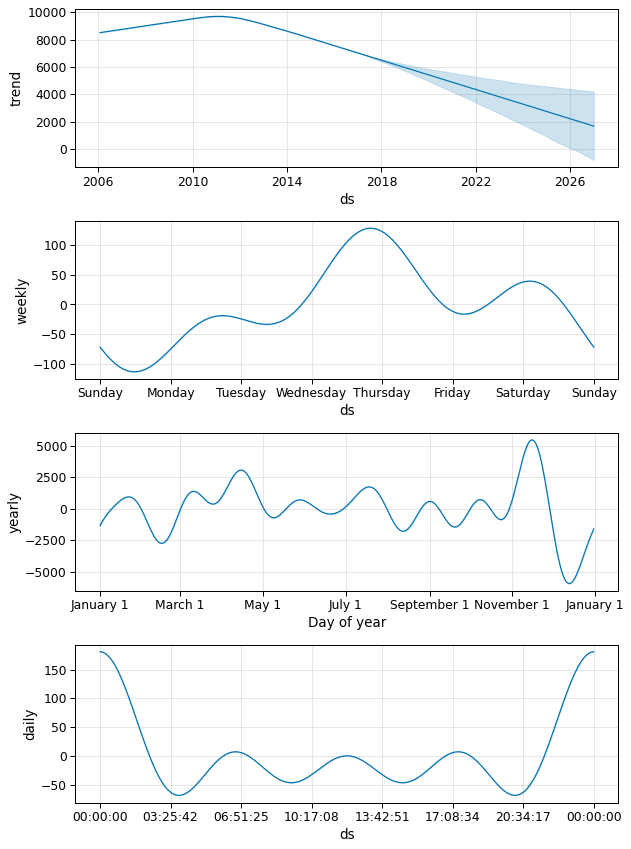

Predicted Number of Crimes: 331.63

Upper Number of Crimes: 2963.49

Lower Number of Crimes: -2280.18

The RMSE of our forecast is 584.21

Predicted % Change: -90.76

Upper % Change: -17.43

Lower % Change: -163.53



In [134]:
prophet_model(brooklyn_crimes_fb)

### 5.4 - Manhattan

In [135]:
manhattan_crimes_fb = crimes_copy.loc['Manhattan']
manhattan_crimes_fb = manhattan_crimes_fb.reset_index()
manhattan_crimes_fb = manhattan_crimes_fb.rename(columns={'Arrest_Date': 'ds', 'Crime_Number': 'y'})
manhattan_crimes_fb

,ds,y
0,2006-01-31,8322
1,2006-02-28,7973
2,2006-03-31,9165
3,2006-04-30,8302
4,2006-05-31,8671
5,2006-06-30,8430
6,2006-07-31,8475
7,2006-08-31,9040
8,2006-09-30,8555
9,2006-10-31,9298


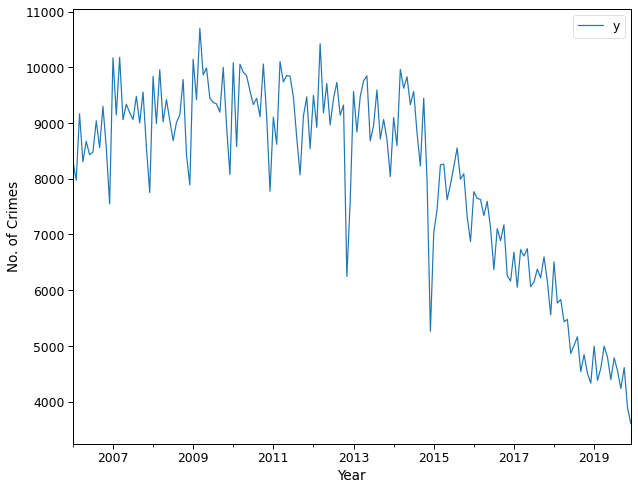

In [136]:
plot_timeseries(manhattan_crimes_fb)

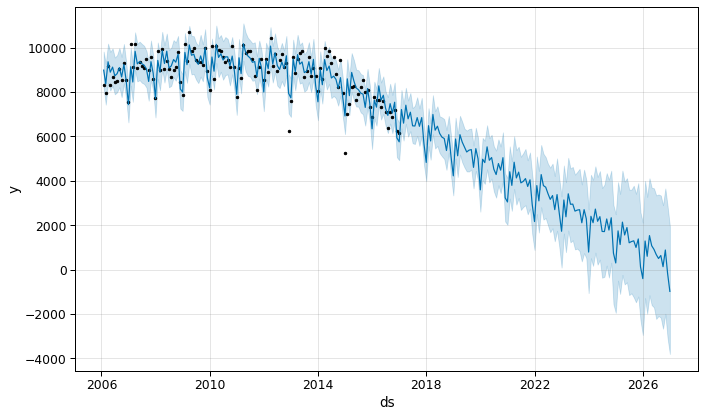

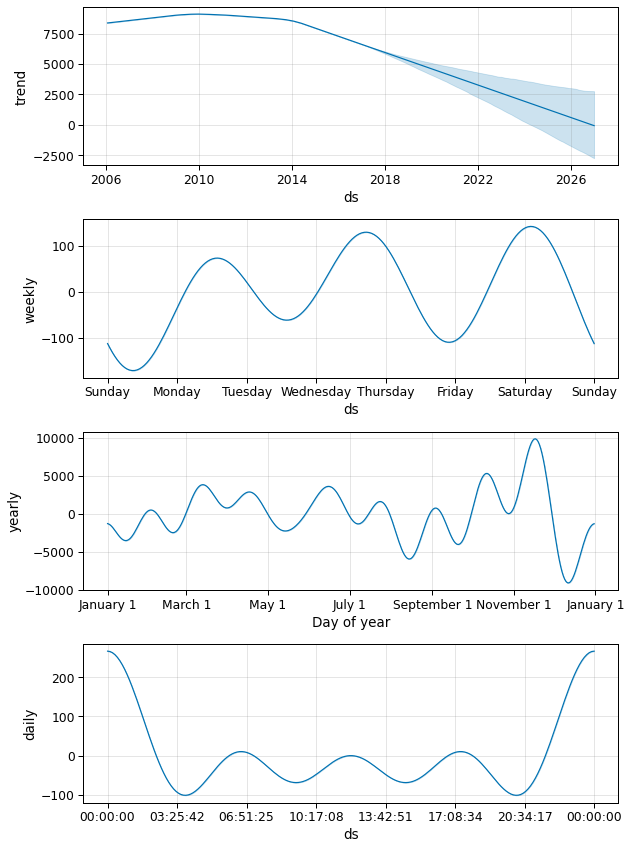

Predicted Number of Crimes: -984.86

Upper Number of Crimes: 1953.67

Lower Number of Crimes: -3804.04

The RMSE of our forecast is 517.92

Predicted % Change: -127.34

Upper % Change: -45.76

Lower % Change: -205.61



In [137]:
prophet_model(manhattan_crimes_fb)

### 5.5 - Queens

In [138]:
queens_crimes_fb = crimes_copy.loc['Queens']
queens_crimes_fb = queens_crimes_fb.reset_index()
queens_crimes_fb = queens_crimes_fb.rename(columns={'Arrest_Date': 'ds', 'Crime_Number': 'y'})
queens_crimes_fb

,ds,y
0,2006-01-31,6026
1,2006-02-28,5538
2,2006-03-31,6554
3,2006-04-30,5969
4,2006-05-31,6497
5,2006-06-30,5723
6,2006-07-31,5644
7,2006-08-31,5766
8,2006-09-30,5591
9,2006-10-31,6000


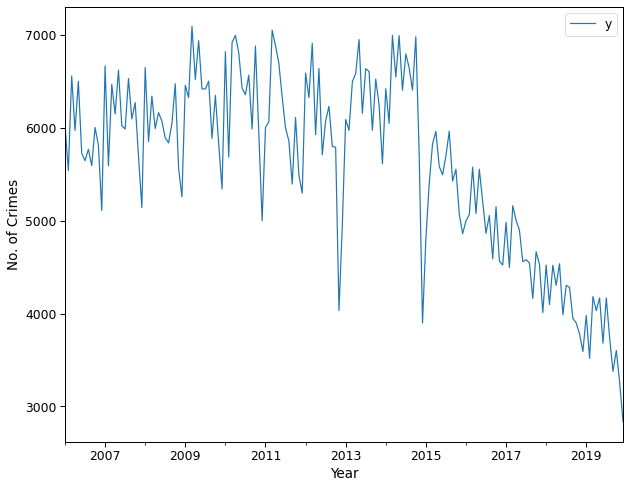

In [139]:
plot_timeseries(queens_crimes_fb)

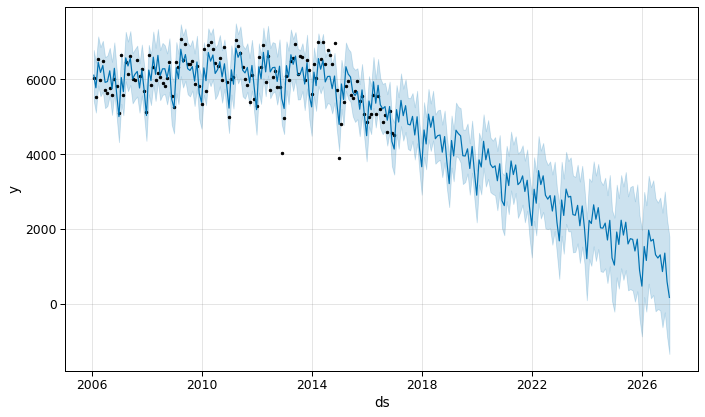

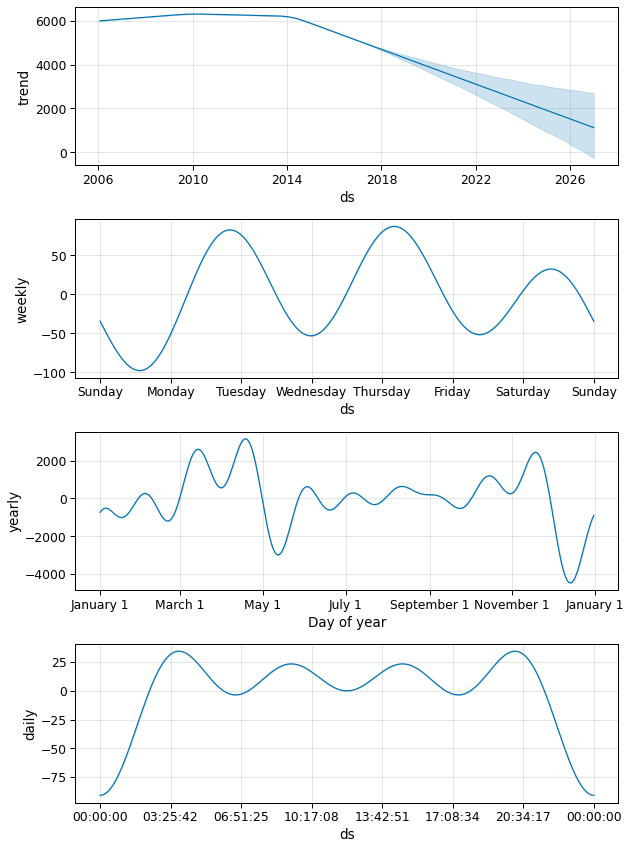

Predicted Number of Crimes: 174.99

Upper Number of Crimes: 1797.61

Lower Number of Crimes: -1335.54

The RMSE of our forecast is 345.29

Predicted % Change: -93.83

Upper % Change: -36.61

Lower % Change: -147.09



In [140]:
prophet_model(queens_crimes_fb)

### 5.6 - Staten Island

In [141]:
staten_crimes_fb = crimes_copy.loc['Staten Island']
staten_crimes_fb = staten_crimes_fb.reset_index()
staten_crimes_fb = staten_crimes_fb.rename(columns={'Arrest_Date': 'ds', 'Crime_Number': 'y'})
staten_crimes_fb

,ds,y
0,2006-01-31,989
1,2006-02-28,861
2,2006-03-31,1021
3,2006-04-30,1038
4,2006-05-31,1187
5,2006-06-30,1122
6,2006-07-31,1103
7,2006-08-31,1135
8,2006-09-30,991
9,2006-10-31,1069


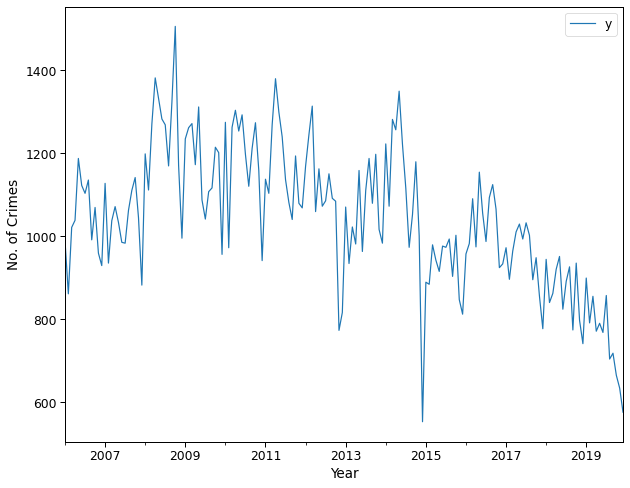

In [142]:
plot_timeseries(staten_crimes_fb)

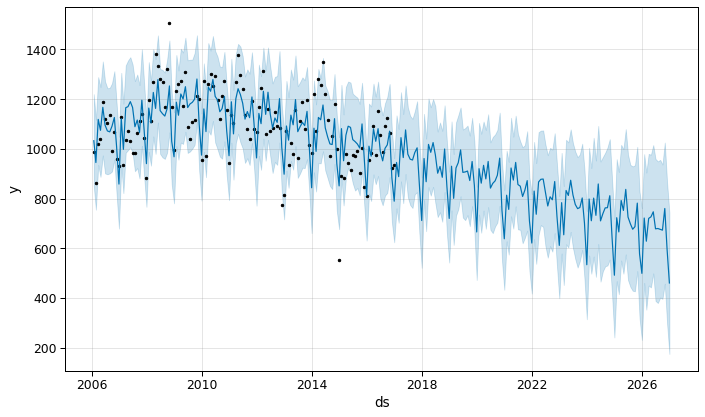

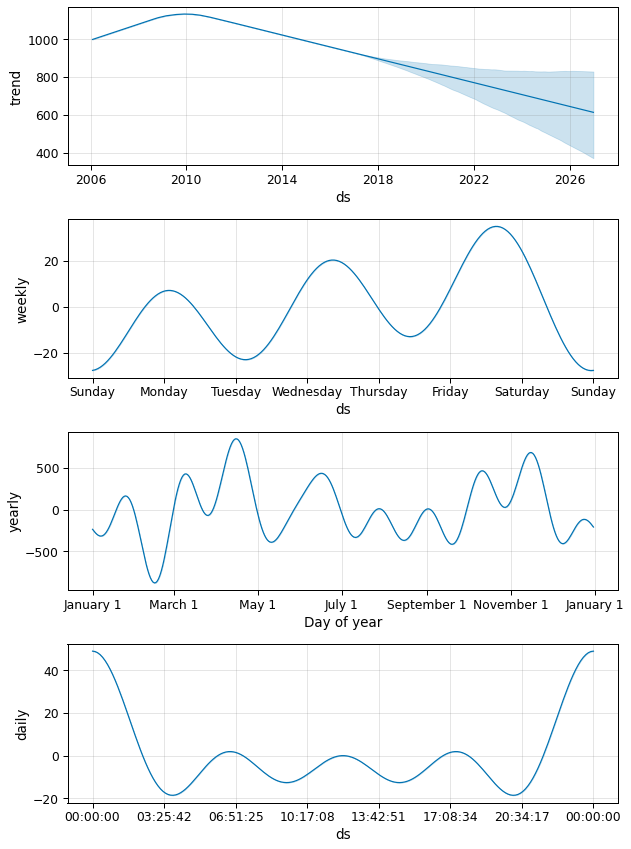

Predicted Number of Crimes: 460.04

Upper Number of Crimes: 743.65

Lower Number of Crimes: 174.28

The RMSE of our forecast is 96.96

Predicted % Change: -20.13

Upper % Change: 29.11

Lower % Change: -69.74



In [143]:
prophet_model(staten_crimes_fb)

## 6. Analysis and Modeling: Holt-Winters Exponential Smoothing

### 6.1 - Functions

In [144]:
def hwes (ts, trend, seasonal):
    
    '''Enter time series data frame, trend (mul or add), and seasonal (mul or add) to train and test Holt-Winters Exponential
    Smoothing. This function also plots future predictions and calculate percentage change & RMSE'''
    
    # split between the training and the test data sets. The last 36 periods form the test data
    ts_train = ts.iloc[:-36]
    ts_test = ts.iloc[-36:]
    
    #build and train the model on the training data
    hwmodel = ExponentialSmoothing(ts_train,trend=trend, seasonal=seasonal, seasonal_periods=12).fit()

    #create an out of sample forcast for the next 120 steps beyond the final data point in the training data set
    test_pred = hwmodel.forecast(steps=120)
    test_pred.to_frame()

    #plot the training data, the test data and the forecast on the same plot
    ts_train['Crime_Number'].plot(legend=True, label='Train', figsize=(10,6))
    ts_test['Crime_Number'].plot(legend=True, label='Test')
    test_pred.plot(legend=True, label='Predicted')
    
    # calculate RMSE
    RMSE = np.sqrt(mean_squared_error(ts_test,test_pred[:36]))
    print('\n' + f'The RMSE of our forecast is {round(RMSE, 2)}' + '\n')

    # Number of crime by end of 2026
    crime_2026 = test_pred.iloc[-1]
    print(f'Predicted Number of Crimes by End of 2026 is {round(crime_2026, 2)}' + '\n')

    # Percent change
    crime_2019 = ts_test['Crime_Number'][-1]
    return_percentage_predictions = {}
    predicted_percent_change = ((crime_2026- crime_2019) / crime_2019)*100
    return_percentage_predictions['Predicted % Change'] = predicted_percent_change
    print(f'Predicted % Change: {round(predicted_percent_change, 2)}' + '\n')

### 6.2 - Bronx

In [145]:
bronx_crimes_hw = crimes_copy.loc['Bronx']


The RMSE of our forecast is 731.95

Predicted Number of Crimes by End of 2026 is 2274.52

Predicted % Change: -24.78



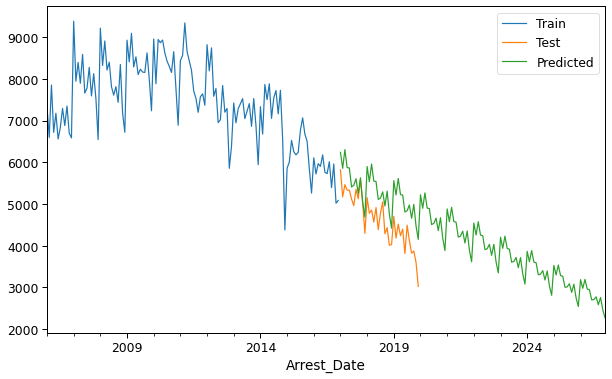

In [146]:
hwes (bronx_crimes_hw, 'add', 'mul')

### 6.3 - Brooklyn

In [147]:
brooklyn_crimes_hw = crimes_copy.loc['Brooklyn']


The RMSE of our forecast is 995.43

Predicted Number of Crimes by End of 2026 is 2342.52

Predicted % Change: -34.73



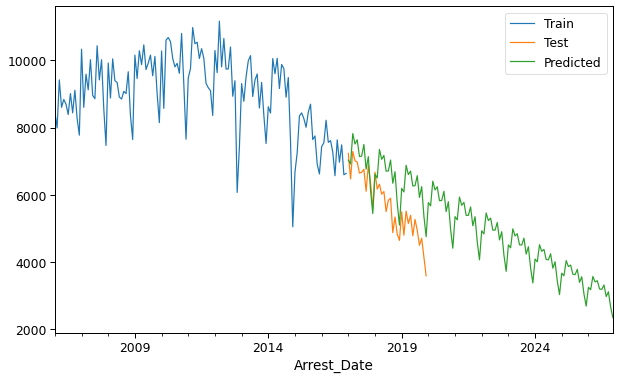

In [148]:
hwes (brooklyn_crimes_hw, 'add', 'mul')

### 6.4 - Manhattan

In [149]:
manhattan_crimes_hw = crimes_copy.loc['Manhattan']


The RMSE of our forecast is 1386.24

Predicted Number of Crimes by End of 2026 is 2112.91

Predicted % Change: -41.34



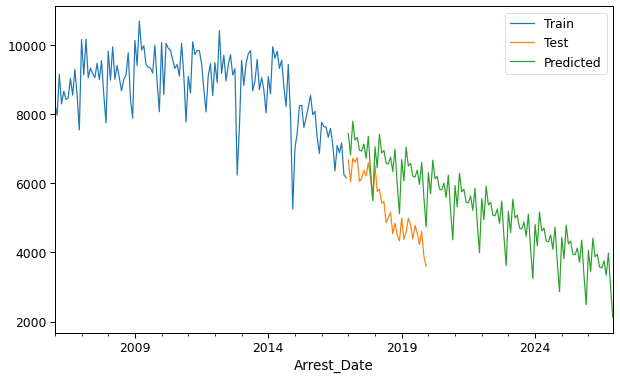

In [150]:
hwes (manhattan_crimes_hw, 'add', 'add')

### 6.5 - Queens

In [151]:
queens_crimes_hw = crimes_copy.loc['Queens']


The RMSE of our forecast is 1146.68

Predicted Number of Crimes by End of 2026 is 3817.03

Predicted % Change: 34.59



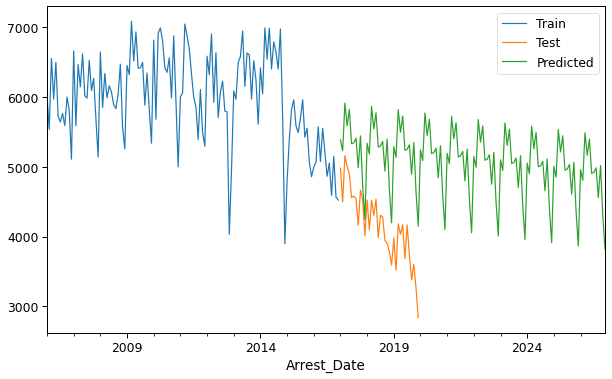

In [152]:
hwes (queens_crimes_hw, 'add', 'add')

### 6.6 - Staten Island

In [153]:
staten_crimes_hw = crimes_copy.loc['Staten Island']


The RMSE of our forecast is 245.61

Predicted Number of Crimes by End of 2026 is 852.17

Predicted % Change: 47.95



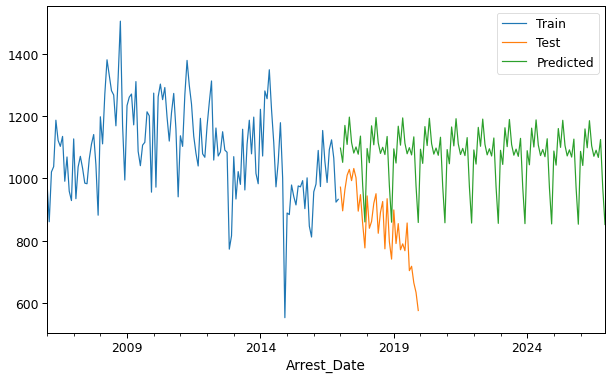

In [154]:
hwes(staten_crimes_hw, 'add', 'mul')

## 7. Conclusion

- According to RMSE values for each model in each borough, SARIMAX is the best model for predicting crimes in NYC.
- Based on the results of the models above, the number of crimes continue to have decreasing trend in the next 5 years.
- SARIMAX - handles seasonality component better 
- Prophet - show outliers and seasonality each year
- HWES - shorter amount of time to train the time series

### 7.1 - Bronx

ARIMA (SARIMAX)
- RMSE = 282.42

Prophet
- RMSE = 439.06

Holt-Winters Exponential Smoothing
- RMSE = 731.95

### 7.2 - Brooklyn

ARIMA (SARIMAX)
- RMSE = 323.85

Prophet
- RMSE = 584.21

Holt-Winters Exponential Smoothing
- RMSE = 995.43

### 7.3 - Manhattan

ARIMA (SARIMAX)
- RMSE = 292.56

Prophet
- RMSE = 517.92

Holt-Winters Exponential Smoothing
- RMSE =1386.24

### 7.4 - Queens

ARIMA (SARIMAX)
- RMSE = 215.85

Prophet
- RMSE = 345.29

Holt-Winters Exponential Smoothing
- RMSE = 1146.68

### 7.5 - Staten Island

ARIMA (SARIMAX)
- RMSE = 68.35

Prophet
- RMSE = 96.96

Holt-Winters Exponential Smoothing
- RMSE = 245.61